# figure 2

# libraries

In [1]:
require(tidyverse)
# require(ComplexHeatmap)
# require(circlize)
# require(Matrix)
# require(singlecellmethods)
# require(presto)
# require(ggthemes)
# require(scales)
# require(ggpubr)

Loading required package: tidyverse

── Attaching core tidyverse packages ──────────────────────────────────────────────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.6
✔ forcats   1.0.1     ✔ stringr   1.6.0
✔ ggplot2   4.0.1     ✔ tibble    3.3.0
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.2.0     
── Conflicts ────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


## load meta data

In [2]:
metadata = readr::read_rds('./input_data/metadata_complete.rds')
metadata$KNN_group = as.vector(metadata$KNN_group)
metadata$knn_renamed_cell_states = as.vector(metadata$knn_renamed_cell_states)
metadata = metadata %>% 
    mutate(KNN_group = ifelse(knn_coarse == 'B', knn_renamed_cell_states, KNN_group)) %>% 
    mutate(knn_renamed_cell_states = ifelse(knn_renamed_cell_states == 'Fibro-CXCL14', 'Fibro-GREM1-low', knn_renamed_cell_states)) 
sample_n(metadata, 10)

,orig.ident,nCount_RNA,nFeature_RNA,area,x,y,n_transcripts,avg_assignment_confidence,cell_id,geometry,fov,knn_coarse,knn_original_cell_states,knn_original_cell_states_confidence,condition,geneformer,geneformer_ClusterTop,cell,knn_renamed_cell_states,KNN_group
,<chr>,<int>,<int>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<chr>,<int>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
G4659-CP-MET_Beta8_490038,G4659-CP-MET_Beta8,152,62,54.826922,8489.707,5806.6456,152,0.8310526,490038,8489.70682617757|5806.64555766469,1650,Epi,cE01 (Stem/TA-like),0.7514453,MSS,gE1 (Epi_Stem/TA)_d,Epi,G4659-CP-MET_Beta8_490038,Epi-Stem_TAlike,Epi
G4595_804128,G4595,30,23,14.093241,12903.063,8179.9290,30,0.7526667,804128,12903.0632668218|8179.92902717786,1356,Epi,cE09 (Best4),0.5483946,MSI,gE1 (Epi_Stem/TA)_d,Epi,G4595_804128,Epi-BEST4,Epi
Jax001_92678,Jax001,54,26,15.273356,1044.016,274.3677,54,0.7118519,92678,1044.01609502928|274.367732489664,127,Strom,cS28 (GREM1+ CAF),0.8985766,MSI,gS07 (S_Peri),Strom,Jax001_92678,Fibro-GREM1,Fibro
C123_393266,C123,123,36,62.787618,7846.572,940.6823,123,0.8759350,393266,7846.57193981488|940.682304361963,980,Strom,cS15/16/17/18/19 (Pericyte),1.0000000,MSI,gS07 (S_Peri),Strom,C123_393266,Pericyte,Pericyte
C164_472474,C164,59,32,31.345871,10547.014,904.4225,59,0.8833898,472474,10547.0143481437|904.422530462775,1363,Myeloid,pM20 (inflammatory)_macrophage,0.4472101,MSI,gM2 (M_Macro),Myeloid,C164_472474,Myeloid-Macro-MMP9-APOE,Myeloid - Macro
Jax001_324468,Jax001,21,17,6.845695,3768.962,4786.3957,21,0.7695238,324468,3768.96188101793|4786.3957171041,759,TNKILC,cTNI14 (CD8+ CXCL13+) & cTNI15 (CD8+ CXCL13+ HSP+),0.5957024,MSI,gM2 (M_Macro),Myeloid,Jax001_324468,Tcd8-CXCL13,Tcd8
G4554_79447,G4554,259,73,99.796440,1778.827,6480.5749,259,0.8336680,79447,1778.82733716338|6480.57489085638,225,Strom,cS31 (CAF stem niche Fibro-like),0.5576695,MSI,gS13 (S_Fibro_GREM1CAF),Strom,G4554_79447,Fibro-StemNiche,Fibro
G4671_401818,G4671,120,58,56.598549,4298.127,4988.7102,120,0.8483333,401818,4298.12652743644|4988.71019878337,1009,Epi,cE01 (Stem/TA-like),0.5977025,MSI,gE1 (Epi_Stem/TA)_d,Epi,G4671_401818,Epi-Stem_TAlike,Epi
G4554_332610,G4554,72,39,68.282445,4691.875,1858.3408,72,0.8269444,332610,4691.87499629592|1858.34078088803,873,Epi,cE01 (Stem/TA-like),0.9495143,MSI,gE3 (Epi_Entero2)_d,Epi,G4554_332610,Epi-Stem_TAlike,Epi


In [3]:
summary(metadata$nCount_RNA)
summary(metadata$nFeature_RNA)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  21.00   36.00   59.00   88.93  106.00 2149.00 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    8.0    21.0    31.0    36.9    46.0   205.0 

## load pathology regions as transferred by pelka lab

In [4]:
pathology_regions = data.table::fread('input_data/adata_concat_metadata.csv') %>%
    select(!V1) %>%
    mutate(orig_cell_id = sample_cell) 

# remove 'submucosa' regions

pathology_regions$pathology_region[pathology_regions$pathology_region == 'non_neoplastic_submucosa'] = 'Unannotated'
pathology_regions$sample_name[pathology_regions$sample_name == 'G4659'] = 'G4659-CP-MET_VMSC04701'
pathology_regions$orig_cell_id[pathology_regions$sample_name == 'G4659-CP-MET_VMSC04701'] = paste0('G4659-CP-MET_VMSC04701_', pathology_regions$cell_id[pathology_regions$sample_name == 'G4659-CP-MET_VMSC04701'])

pathology_regions$sample_name[pathology_regions$sample_name == 'G4659_Beta8'] = 'G4659-CP-MET_Beta8'
pathology_regions$orig_cell_id[pathology_regions$sample_name == 'G4659-CP-MET_Beta8'] = paste0('G4659-CP-MET_Beta8_', pathology_regions$cell_id[pathology_regions$sample_name == 'G4659-CP-MET_Beta8'])

pathology_regions$sample_cell = paste0(pathology_regions$sample_name, '_', pathology_regions$cell_id)
pathology_regions$orig_cell_id = paste0(pathology_regions$sample_name, '_', pathology_regions$cell_id)

In [5]:
pathology_regions$MSstatus[pathology_regions$sample_name == 'C107'] %>% unique

[1] "MSS"

In [6]:
glimpse(pathology_regions)

Rows: 6,275,113
Columns: 25
$ sample_cell         <chr> "C107_0", "C107_1", "C107_2", "C107_4", "C107_6", …
$ PatientID           <chr> "C107", "C107", "C107", "C107", "C107", "C107", "C…
$ sample_name         <chr> "C107", "C107", "C107", "C107", "C107", "C107", "C…
$ MMRstatus           <chr> "MMRp", "MMRp", "MMRp", "MMRp", "MMRp", "MMRp", "M…
$ MSstatus            <chr> "MSS", "MSS", "MSS", "MSS", "MSS", "MSS", "MSS", "…
$ MLH1Sstatus         <chr> "Non-Methylated", "Non-Methylated", "Non-Methylate…
$ TissueSite          <chr> "Right", "Right", "Right", "Right", "Right", "Righ…
$ PathStage           <dbl> 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,…
$ Sex                 <chr> "M", "M", "M", "M", "M", "M", "M", "M", "M", "M", …
$ pathology_region    <chr> "tumor", "tumor", "tumor", "tumor", "tumor", "tumo…
$ KNN_Top             <chr> "Strom", "Strom", "Strom", "Strom", "Epi", "Myeloi…
$ KNN_Mid             <chr> "Fibro", "Fibro", "Peri", "Fibro", "Epi", "Myeloid…
$ KNN_cellty

# Collect the numbers of cells per CXCR3L mask niche type

In [7]:
pelka_data = data.table::fread('input_data/single_cell_annots_tessera_niches_clean.csv') # https://drive.google.com/file/d/1eVHFecT3O8ZPdYnIZh_i4HVUbxRRLhpg/view?usp=drive_link
glimpse(pelka_data)

Rows: 6,275,113
Columns: 27
$ sample_cell            <chr> "C107_0", "C107_1", "C107_2", "C107_4", "C107_6…
$ PatientID              <chr> "C107", "C107", "C107", "C107", "C107", "C107",…
$ sample_name            <chr> "C107", "C107", "C107", "C107", "C107", "C107",…
$ MMRstatus              <chr> "MMRp", "MMRp", "MMRp", "MMRp", "MMRp", "MMRp",…
$ MSstatus               <chr> "MSS", "MSS", "MSS", "MSS", "MSS", "MSS", "MSS"…
$ MLH1Sstatus            <chr> "Non-Methylated", "Non-Methylated", "Non-Methyl…
$ TissueSite             <chr> "Right", "Right", "Right", "Right", "Right", "R…
$ PathStage              <int> 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,…
$ Sex                    <chr> "M", "M", "M", "M", "M", "M", "M", "M", "M", "M…
$ pathology_region       <chr> "tumor", "tumor", "tumor", "tumor", "tumor", "t…
$ KNN_Top                <chr> "Strom", "Strom", "Strom", "Strom", "Epi", "Mye…
$ KNN_Mid                <chr> "Fibro", "Fibro", "Peri", "Fibro", "Epi", "Myel…
$ KNN_cellty

In [8]:
unique(pelka_data$tessera_annotation)

[1] "strom_dom" "epi_dom"   NA          "non_tumor"

In [9]:
pelka_data %>%
    filter(!is.na(tessera_annotation)) %>%
    filter(tessera_annotation!='non_tumor') %>%
    filter(cxcl_pos_tile == 'CXCL_pos') %>%
    select(cell_id, cxcl_niche, tessera_annotation) %>%
    group_by(cxcl_niche) %>%
    mutate(region_type = case_when(
    # If the number of distinct cell types in the group is > 1, it must be mixed
    n_distinct(tessera_annotation) > 1 ~ "mixed",
    # If not mixed, check the first value to decide the type
    first(tessera_annotation) == "epi_dom" ~ "epi only",
    first(tessera_annotation) == "strom_dom" ~ "strom only"
  )) %>%
  ungroup() %>% # Always good practice to ungroup afterwards 
    group_by(region_type) %>%
    summarize(n = n())

region_type,n
<chr>,<int>
epi only,53995
mixed,1068092
strom only,42299


In [10]:
pelka_data %>%
    filter(!is.na(tessera_annotation)) %>%
    filter(tessera_annotation!='non_tumor') %>%
    filter(cxcl_pos_tile == 'CXCL_pos') %>%
    select(cxcl_niche, tessera_annotation) %>%
    distinct() %>%
    group_by(cxcl_niche) %>%
    mutate(region_type = case_when(
    # If the number of distinct cell types in the group is > 1, it must be mixed
    n_distinct(tessera_annotation) > 1 ~ "mixed",
    # If not mixed, check the first value to decide the type
    first(tessera_annotation) == "epi_dom" ~ "epi only",
    first(tessera_annotation) == "strom_dom" ~ "strom only"
  )) %>%
     ungroup() %>% # Always good practice to ungroup afterwards 
    group_by(region_type) %>%
    summarize(n = n())

region_type,n
<chr>,<int>
epi only,1192
mixed,2572
strom only,1442


In [11]:
pelka_data %>%
    filter(!is.na(tessera_annotation)) %>%
    filter(tessera_annotation!='non_tumor') %>%
    filter(cxcl_pos_tile == 'CXCL_pos') %>%
    select(cell_id, cxcl_niche, tessera_annotation) %>%
    group_by(cxcl_niche) %>%
    mutate(region_type = case_when(
    # If the number of distinct cell types in the group is > 1, it must be mixed
    n_distinct(tessera_annotation) > 1 ~ "mixed",
    # If not mixed, check the first value to decide the type
    first(tessera_annotation) == "epi_dom" ~ "epi only",
    first(tessera_annotation) == "strom_dom" ~ "strom only"
  )) %>%
  ungroup() %>% # Always good practice to ungroup afterwards 
    group_by(region_type) %>%
    summarize(n = n())

region_type,n
<chr>,<int>
epi only,53995
mixed,1068092
strom only,42299


In [12]:
pelka_data %>%
    filter(!is.na(tessera_annotation)) %>%
    filter(tessera_annotation!='non_tumor') %>%
    filter(cxcl_pos_tile == 'CXCL_pos') %>%
    select(cell_id, cxcl_niche, tessera_annotation) %>%
    group_by(cxcl_niche) %>%
    mutate(region_type = case_when(
    # If the number of distinct cell types in the group is > 1, it must be mixed
    n_distinct(tessera_annotation) > 1 ~ "mixed",
    # If not mixed, check the first value to decide the type
    first(tessera_annotation) == "epi_dom" ~ "epi only",
    first(tessera_annotation) == "strom_dom" ~ "strom only"
  )) %>%
  ungroup() %>% # Always good practice to ungroup afterwards 
    group_by(region_type) %>%
    summarize(n = n())

region_type,n
<chr>,<int>
epi only,53995
mixed,1068092
strom only,42299


In [13]:
pelka_data %>%
    filter(!is.na(tessera_annotation)) %>%
    filter(tessera_annotation!='non_tumor') %>%
    filter(cxcl_pos_tile == 'CXCL_pos') %>%
    select(cell_id, cxcl_niche, tessera_annotation) %>%
    group_by(cxcl_niche) %>%
    mutate(region_type = case_when(
    # If the number of distinct cell types in the group is > 1, it must be mixed
    n_distinct(tessera_annotation) > 1 ~ "mixed",
    # If not mixed, check the first value to decide the type
    first(tessera_annotation) == "epi_dom" ~ "epi only",
    first(tessera_annotation) == "strom_dom" ~ "strom only"
  )) %>%
  ungroup() %>% # Always good practice to ungroup afterwards 
    filter(region_type == 'mixed') %>%
    group_by(cxcl_niche) %>%
    summarize(n = n()) %>%
    top_n(n = 10, wt = n) %>%
    arrange(desc(n))

cxcl_niche,n
<chr>,<int>
cxcl_Jax001_i479,109342
cxcl_C110_i184,73035
cxcl_G4595_i502,64960
cxcl_G4671_i179,46287
cxcl_Jax001_i101,37385
cxcl_Jax001_i100,35516
cxcl_C164_i7,30076
cxcl_Jax001_i343,24901
cxcl_G4671_i397,22853


In [14]:
pelka_data %>%
    filter(!is.na(tessera_annotation)) %>%
    filter(tessera_annotation!='non_tumor') %>%
    filter(cxcl_pos_tile == 'CXCL_pos') %>%
    select(cell_id, cxcl_niche, tessera_annotation) %>%
    group_by(cxcl_niche) %>%
    mutate(region_type = case_when(
    # If the number of distinct cell types in the group is > 1, it must be mixed
    n_distinct(tessera_annotation) > 1 ~ "mixed",
    # If not mixed, check the first value to decide the type
    first(tessera_annotation) == "epi_dom" ~ "epi only",
    first(tessera_annotation) == "strom_dom" ~ "strom only"
  )) %>%
  ungroup() %>% # Always good practice to ungroup afterwards 
    filter(region_type == 'mixed') %>%
    group_by(cxcl_niche) %>%
    summarize(n = n()) %>%
    pull(n) %>%
    summary()

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
     9.0     71.0    132.0    830.6    307.5 109342.0 

In [15]:
pelka_data %>%
    filter(!is.na(tessera_annotation)) %>%
    filter(tessera_annotation!='non_tumor') %>%
    filter(cxcl_pos_tile == 'CXCL_pos') %>%
    select(cell_id, cxcl_niche, tessera_annotation) %>%
    group_by(cxcl_niche) %>%
    mutate(region_type = case_when(
    # If the number of distinct cell types in the group is > 1, it must be mixed
    n_distinct(tessera_annotation) > 1 ~ "mixed",
    # If not mixed, check the first value to decide the type
    first(tessera_annotation) == "epi_dom" ~ "epi only",
    first(tessera_annotation) == "strom_dom" ~ "strom only"
  )) %>%
  ungroup() %>% # Always good practice to ungroup afterwards 
    group_by(cxcl_niche, region_type) %>%
    summarize(n = n()) %>%
    ungroup %>%
    group_by(region_type) %>%
    summarize(min = min(n),
             max = max(n),
             median = median(n),
              mean = mean(n),
              sd = sd(n)
             ) %>%
    as.data.frame

`summarise()` has grouped output by 'cxcl_niche'. You can override using the `.groups` argument.


region_type,min,max,median,mean,sd
<chr>,<int>,<int>,<dbl>,<dbl>,<dbl>
epi only,2,706,36,45.29782,45.77174
mixed,9,109342,132,830.55365,4889.23803
strom only,2,1758,14,29.33356,60.63001


In [16]:
glimpse(pelka_data)

Rows: 6,275,113
Columns: 27
$ sample_cell            <chr> "C107_0", "C107_1", "C107_2", "C107_4", "C107_6…
$ PatientID              <chr> "C107", "C107", "C107", "C107", "C107", "C107",…
$ sample_name            <chr> "C107", "C107", "C107", "C107", "C107", "C107",…
$ MMRstatus              <chr> "MMRp", "MMRp", "MMRp", "MMRp", "MMRp", "MMRp",…
$ MSstatus               <chr> "MSS", "MSS", "MSS", "MSS", "MSS", "MSS", "MSS"…
$ MLH1Sstatus            <chr> "Non-Methylated", "Non-Methylated", "Non-Methyl…
$ TissueSite             <chr> "Right", "Right", "Right", "Right", "Right", "R…
$ PathStage              <int> 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,…
$ Sex                    <chr> "M", "M", "M", "M", "M", "M", "M", "M", "M", "M…
$ pathology_region       <chr> "tumor", "tumor", "tumor", "tumor", "tumor", "t…
$ KNN_Top                <chr> "Strom", "Strom", "Strom", "Strom", "Epi", "Mye…
$ KNN_Mid                <chr> "Fibro", "Fibro", "Peri", "Fibro", "Epi", "Myel…
$ KNN_cellty

In [ ]:
tb_mask_annotations = fread('input_data/suggested_filter_for_tb_mask.csv')


In [ ]:
glimpse(tb_mask_annotations)

In [ ]:
tb_mask_annotations$TB_niche %>% unique %>% length

In [ ]:
tb_mask_annotations %>%
    select(TB_niche, TB_pathology_region) %>%
    distinct %>%
    group_by(TB_pathology_region) %>%
    summarize(n = n())

In [ ]:
tb_mask_annotations %>%
    select(TB_niche, TB_pathology_region) %>%
    group_by(TB_pathology_region) %>%
    summarize(n = n())

In [ ]:
tb_mask_annotations %>%
    filter(TB_pathology_region == 'TB_intratumor') %>%
    select(TB_niche, cell_id) %>%
    group_by(TB_niche) %>%
    summarize(n = n()) %>%
    ungroup %>%
    summarize(min = min(n),
             max = max(n),
             median = median(n),
              mean = mean(n),
              sd = sd(n)
             ) %>%
    as.data.frame

In [ ]:
glimpse(tb_mask_annotations)

In [ ]:
unique(tb_mask_annotations$pathology_region)

In [ ]:
tb_mask_annotations %>%
    filter(pathology_region %in% c('non_neoplastic_mucosa', 'tumor')) %>%
    group_by(TB_pos_tile) %>%
    summarize(n = n()) %>%
    ungroup %>%
    mutate(percent = 100*n/sum(n))

In [ ]:
tb_mask_annotations %>%
    filter(pathology_region %in% c('non_neoplastic_other')) %>%
    group_by(TB_pos_tile) %>%
    summarize(n = n()) %>%
    ungroup %>%
    mutate(percent = 100*n/sum(n))

In [ ]:
tb_mask_annotations %>%
    filter(pathology_region == 'lymphoid_structure') %>%
    group_by(TB_pos_tile) %>%
    summarize(n = n()) %>%
    ungroup %>%
    mutate(percent = 100*n/sum(n))

In [ ]:
tb_mask_annotations %>% glimpse()

In [ ]:
tb_mask_annotations$cxcl_niche_comp  %>% unique

In [ ]:
# proportion of stromal anti tumor hubs in the TB mask
#tb_mask_annotations %>% glimpse
tb_mask_annotations %>%
    filter(cxcl_pos_tile == 'CXCL_pos') %>%
    group_by(TB_pos_tile, cxcl_niche_comp) %>%
    summarize(n = n()) %>%
    ungroup %>%
    group_by(cxcl_niche_comp) %>%
    mutate(percent = 100*n/sum(n)) 

# Of the cells in the intratumoral T/B cell mask, 11.5% were assigned to the stromal anti-tumor hubs, and 19.3% were assigned to the interface anti-tumor hubs 

In [ ]:
# Of the cells in the intratumoral T/B cell mask, 11.5% were assigned to the stromal anti-tumor hubs, and 19.3% were assigned to the interface anti-tumor hubs 
tb_mask_annotations %>%
    filter(tessera_annotation != 'non_tumor') %>%
    filter(TB_pos_tile == 'TB_pos') %>%
    group_by(TB_pos_tile, cxcl_niche_comp, cxcl_pos_tile) %>%
    summarize(n = n()) %>%
    ungroup %>%
    mutate(percent = 100*n/sum(n)) 

# Conversely, 8.9% of cells in stromal anti-tumor hub niches and only 0.6% of cells in interface anti-tumor hub niches were assigned to the T/B cell masks

## considering all TB mask cells

In [ ]:
tb_mask_annotations %>%
    filter(cxcl_pos_tile == 'CXCL_pos') %>%
    group_by(cxcl_niche_comp, TB_pos_tile) %>%
    summarize(n = n()) %>%
    ungroup %>%
    group_by(cxcl_niche_comp) %>%
    mutate(percent = 100*n/sum(n)) %>%
    ungroup
# 8.9% of cells in stromal anti-tumor hub niches were also assigned to the T/B cell masks.
# 0.6% of cells in interface anti-tumor hub niches were also assigned to the T/B cell masks.

## considering only intratumoral TB masks

In [ ]:
table(tb_mask_annotations$tessera_annotation, tb_mask_annotations$TB_pos_tile, useNA = 'always')

In [ ]:
tb_mask_annotations %>%
    filter(tessera_annotation != 'non_tumor') %>%
    filter(cxcl_pos_tile == 'CXCL_pos') %>%
    group_by(cxcl_niche_comp, TB_pos_tile) %>%
    summarize(n = n()) %>%
    ungroup %>%
    group_by(cxcl_niche_comp) %>%
    mutate(percent = 100*n/sum(n)) %>%
    ungroup
# 8.9% of cells in stromal anti-tumor hub niches were also assigned to the T/B cell masks.
# 0.6% of cells in interface anti-tumor hub niches were also assigned to the T/B cell masks.

In [ ]:
tb_mask_annotations %>%
    #filter(tessera_annotation != 'non_tumor') %>%
    filter(cxcl_pos_tile == 'CXCL_pos') %>%
    group_by(cxcl_niche_comp, TB_pos_tile) %>%
    summarize(n = n()) %>%
    ungroup %>%
    group_by(cxcl_niche_comp) %>%
    mutate(percent = 100*n/sum(n)) %>%
    ungroup
# 8.9% of cells in stromal anti-tumor hub niches were also assigned to the T/B cell masks.
# 0.6% of cells in interface anti-tumor hub niches were also assigned to the T/B cell masks.

In [ ]:
tb_mask_annotations %>%
    filter(cxcl_pos_tile == 'CXCL_pos') %>%
    filter(cxcl_niche_comp != '') %>%
    filter(tessera_annotation != 'non_tumor') %>%
    group_by(cxcl_niche_comp, TB_pos_tile) %>%
    summarize(n = n()) %>%
    ungroup %>%
    mutate(percent = 100*n/sum(n)) 

In [ ]:
tb_mask_annotations %>%
    filter(cxcl_pos_tile == 'CXCL_pos') %>%
    group_by(TB_pos_tile, cxcl_niche_comp) %>%
    summarize(n = n()) %>%
    ungroup %>%
    mutate(percent = 100*n/sum(n)) 

# QC the pathology regions

In [17]:
pathology_regions = pathology_regions %>%
    mutate(condition = MSstatus,
          knn_renamed_cell_states = KNN_celltype_v2,
          orig.ident = sample_name,
          knn_coarse = KNN_Top,
          #pathology_region = ifelse(grepl(pathology_region, pattern = 'tumor'), yes = 'tumor', no = pathology_region),
          ) %>%
    mutate(knn_coarse = ifelse(knn_coarse == 'Mast', yes = 'Myeloid', no = ifelse(knn_coarse %in% c('B', 'Plasma'), yes = 'Bplasma', no = knn_coarse))) %>%
    mutate(knn_renamed_cell_states = ifelse(knn_coarse == 'Epi', yes = 'Epi', no = knn_renamed_cell_states)) %>%
    mutate(knn_renamed_cell_states = ifelse(knn_renamed_cell_states == 'Fibro-CXCL14', 'Fibro-GREM1-low', knn_renamed_cell_states)) %>% 
    mutate(pathology_region = gsub(pathology_region, pattern = '_', replacement = ' ')) %>%
    mutate(pathology_region = str_to_title(pathology_region)) %>%
    mutate(pathology_region = gsub(pathology_region, pattern = 'Muscularis Propria', 
                                   replacement = 'Non-neo. other')) %>%
    mutate(pathology_region = gsub(pathology_region, pattern = 'Non Neoplastic Mucosa', 
                                   replacement = 'Non-neo. mucosa')) %>%
    mutate(pathology_region = gsub(pathology_region, 
                                   pattern = 'Non Neoplastic Submucosa|non_neoplastic_submucosa', replacement = 'Non-neo. other')) %>%  #'Non-neo. submuc.'
    mutate(pathology_region = gsub(pathology_region, 
                                   pattern = 'Tumor Invasive Margin', replacement = 'Tumor Invasive Border')) %>% #inv-border
    mutate(pathology_region = gsub(pathology_region, 
                                   pattern = 'Tumor Luminal Margin', replacement = 'Tumor Luminal Surface')) #lum-border

In [18]:
sample_n(pathology_regions, 10)

sample_cell,PatientID,sample_name,MMRstatus,MSstatus,MLH1Sstatus,TissueSite,PathStage,Sex,pathology_region,⋯,total_counts,id,CXCL_Niche_Cluster,CCL19_Niche_Cluster,CXCL_CCL19_Cluster,orig_cell_id,condition,knn_renamed_cell_states,orig.ident,knn_coarse
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,⋯,<int>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
Jax001_485187,Jax001,Jax001,MMRd,MSI,Non-Methylated,Right,3,M,Tumor,⋯,72,6071993,cluster_3,cluster_unassigned,cluster_3|cluster_unassigned,Jax001_485187,MSI,Fibro-stemNiche,Jax001,Strom
G4738_Beta10_08_161132,G4738,G4738_Beta10_08,MMRp,MSS,Non-Methylated,Right,2,M,Tumor,⋯,25,4333478,cluster_unassigned,cluster_unassigned,cluster_unassigned|cluster_unassigned,G4738_Beta10_08_161132,MSS,Fibro-stemNiche,G4738_Beta10_08,Strom
C110_194609,C110,C110,MMRd,MSI,Methylated,Right,3,M,Tumor,⋯,24,235214,cluster_1,cluster_unassigned,cluster_1|cluster_unassigned,C110_194609,MSI,Epi,C110,Epi
G4669_reg1_279886,G4669,G4669_reg1,MMRp,MSS,Non-Methylated,Left,1,F,Tumor,⋯,71,2500445,cluster_unassigned,cluster_unassigned,cluster_unassigned|cluster_unassigned,G4669_reg1_279886,MSS,Epi,G4669_reg1,Epi
G4712_Beta10_201775,G4712,G4712_Beta10,MMRp,MSS,Non-Methylated,Right,3,M,Tumor,⋯,116,3616369,cluster_unassigned,cluster_unassigned,cluster_unassigned|cluster_unassigned,G4712_Beta10_201775,MSS,Myeloid-Macro-SEPP1-LYVE1,G4712_Beta10,Myeloid
G4712_Beta8_651352,G4712,G4712_Beta8,MMRp,MSS,Non-Methylated,Right,3,M,Tumor,⋯,124,3352959,cluster_unassigned,cluster_unassigned,cluster_unassigned|cluster_unassigned,G4712_Beta8_651352,MSS,Fibro-BMP,G4712_Beta8,Strom
C107_128947,C107,C107,MMRp,MSS,Non-Methylated,Right,3,M,Tumor,⋯,66,80596,cluster_3,cluster_unassigned,cluster_3|cluster_unassigned,C107_128947,MSS,Epi,C107,Epi
G4554_385728,G4554,G4554,MMRd,MSI,Non-Methylated,Right,3,F,Tumor,⋯,346,4814497,cluster_unassigned,cluster_unassigned,cluster_unassigned|cluster_unassigned,G4554_385728,MSI,Fibro-stemNiche,G4554,Strom
G4671_216987,G4671,G4671,MMRd,MSI,Methylated,Right,3,F,Tumor,⋯,76,2652000,cluster_unassigned,cluster_unassigned,cluster_unassigned|cluster_unassigned,G4671_216987,MSI,Epi,G4671,Epi


## frequencies of region per sample show that some regions are extremely small and must be removed

In [19]:
.x = metadata %>% 
    left_join(., pathology_regions %>% select(sample_cell, pathology_region, PatientID) %>% rename(cell = sample_cell)) %>%
    mutate(pathology_region = gsub(pathology_region, pattern = '_', replacement = ' '))
table(.x$pathology_region, .x$orig.ident) %>% as.data.frame %>% filter(Freq > 0)

Joining with `by = join_by(cell)`


Var1,Var2,Freq
<fct>,<fct>,<int>
Tumor,C107,127411
Lymphoid Structure,C110,893
Non-neo. other,C110,76
Tumor,C110,140428
Tumor Luminal Surface,C110,12084
Unannotated,C110,2197
Lymphoid Structure,C123,1937
Non-neo. mucosa,C123,19193
Tumor,C123,239114


In [20]:
table(.x$pathology_region, .x$orig.ident) %>% as.data.frame %>% filter(Freq > 0) %>% 
pivot_wider(names_from = Var1, values_from = Freq, values_fill = 0)

Var2,Tumor,Lymphoid Structure,Non-neo. other,Tumor Luminal Surface,Unannotated,Non-neo. mucosa,Tumor Invasive Border
<fct>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
C107,127411,0,0,0,0,0,0
C110,140428,893,76,12084,2197,0,0
C123,239114,1937,0,40030,2186,19193,4290
C164,412933,238,585,36228,11217,30,8301
G4423,154743,12331,0,52042,17178,49968,33095
G4554,492575,0,9581,41263,8974,11346,0
G4595,522477,139,0,49291,9123,0,30956
G4630,362871,0,0,1107,297,0,0
G4659-CP-MET_Beta8,204371,847,36598,42629,103903,15427,0


In [21]:
table(.x$pathology_region, .x$orig.ident) %>% as.data.frame %>% filter(Freq < 250 & Freq > 0)

Var1,Var2,Freq
<fct>,<fct>,<int>
Non-neo. other,C110,76
Lymphoid Structure,C164,238
Non-neo. mucosa,C164,30
Lymphoid Structure,G4595,139
Lymphoid Structure,G4659-CP-MET_VMSC04701,13
Non-neo. other,G4671,4


In [22]:
table(.x$pathology_region, .x$PatientID) %>% as.data.frame %>% filter(Freq > 250) %>% 
pivot_wider(names_from = Var1, values_from = Freq, values_fill = 0) %>%
tibble::column_to_rownames('Var2')

,Tumor,Lymphoid Structure,Tumor Luminal Surface,Unannotated,Non-neo. mucosa,Tumor Invasive Border,Non-neo. other
,<int>,<int>,<int>,<int>,<int>,<int>,<int>
C107,127411,0,0,0,0,0,0
C110,140428,893,12084,2197,0,0,0
C123,239114,1937,40030,2186,19193,4290,0
C164,412933,0,36228,11217,0,8301,585
G4423,154743,12331,52042,17178,49968,33095,0
G4554,492575,0,41263,8974,11346,0,9581
G4595,522477,0,49291,9123,0,30956,0
G4630,362871,0,1107,297,0,0,0
G4659,361429,860,68535,105344,16024,0,37426


## QC regions < 250 cells

In [23]:
table(.x$pathology_region, 
      .x$PatientID) %>% 
    as.data.frame %>% 
    filter(Freq > 250) %>%
    select(Var1, Var2) %>%
    rename(pathology_region = Var1, PatientID = Var2) %>%
    mutate(pathology_region_PatientID = paste0(pathology_region, '_', PatientID))

selected_pathology_regions = table(.x$pathology_region, 
      .x$PatientID) %>% 
    as.data.frame %>% 
    filter(Freq > 250) %>%
    select(Var1, Var2) %>%
    rename(pathology_region = Var1, PatientID = Var2) %>%
    mutate(pathology_region_PatientID = paste0(pathology_region, '_', PatientID)) %>%
    pull(pathology_region_PatientID)

pathology_region,PatientID,pathology_region_PatientID
<fct>,<fct>,<chr>
Tumor,C107,Tumor_C107
Lymphoid Structure,C110,Lymphoid Structure_C110
Tumor,C110,Tumor_C110
Tumor Luminal Surface,C110,Tumor Luminal Surface_C110
Unannotated,C110,Unannotated_C110
Lymphoid Structure,C123,Lymphoid Structure_C123
Non-neo. mucosa,C123,Non-neo. mucosa_C123
Tumor,C123,Tumor_C123
Tumor Invasive Border,C123,Tumor Invasive Border_C123


In [24]:
pathology_regions %>% dim
pathology_regions_preQC = pathology_regions
pathology_regions = pathology_regions %>% 
    mutate(pathology_region_PatientID = paste0(pathology_region, '_', PatientID)) %>%
    filter(pathology_region_PatientID %in% selected_pathology_regions) 
pathology_regions %>%
    dim

[1] 6275113      29

[1] 6274626      30

In [25]:
data.table::fwrite(pathology_regions, 'figs/pathology_regions_postQC.csv')

In [26]:
getwd()

[1] "D:/Data/final_data_backup/CRC_MERFISH/Pathology_annotations/figure2"

In [ ]:
nCells_pathology = pathology_regions %>% 
    left_join(., metadata %>% select(cell_id, orig.ident, area)) %>%
    mutate(orig.ident = gsub(orig.ident, pattern = '_.*', replacement = '')) %>%
    select(condition, knn_renamed_cell_states, orig.ident, KNN_Top, pathology_region, area) %>%
    group_by(orig.ident, knn_renamed_cell_states, condition, KNN_Top, pathology_region) %>%
    summarize(total_cell_state = n(), cell_state_area = sum(area), .groups = 'keep') %>%
    ungroup %>%
    group_by(orig.ident, condition, pathology_region, .drop = FALSE) %>%
    mutate(total_region = sum(total_cell_state), total_region_area = sum(cell_state_area)) %>%
    ungroup %>%
    group_by(orig.ident, .drop = FALSE) %>%
    mutate(total_cells = sum(total_cell_state), total_area = sum(total_region_area)) %>%
    mutate(cell_state_as_percent_of_total = 100*total_cell_state/total_cells, cell_state_as_percent_of_region = 100*total_cell_state/total_region, cell_state_density_area = cell_state_area/total_region_area) %>%
    ungroup 

nCells_pathology %>%
    sample_n(20)

In [ ]:
dim(nCells_pathology)

In [ ]:
unique(metadata$knn_renamed_cell_states)
unique(pathology_regions$knn_renamed_cell_states)

# figure 1f: compare frequencies of cell states within MSI and MSS tumor

In [19]:
colnames(metadata)

[1] "orig.ident"                          "nCount_RNA"                         
 [3] "nFeature_RNA"                        "area"                               
 [5] "x"                                   "y"                                  
 [7] "n_transcripts"                       "avg_assignment_confidence"          
 [9] "cell_id"                             "geometry"                           
[11] "fov"                                 "knn_coarse"                         
[13] "knn_original_cell_states"            "knn_original_cell_states_confidence"
[15] "condition"                           "geneformer"                         
[17] "geneformer_ClusterTop"               "cell"                               
[19] "knn_renamed_cell_states"             "KNN_group"

In [20]:
.temp = pathology_regions %>% 
    left_join(., metadata %>% select(cell_id, orig.ident, area)) %>%
    mutate(orig.ident = gsub(orig.ident, pattern = '_.*', replacement = '')) %>%
    select(condition, orig.ident, KNN_Grouped, KNN_Top, knn_renamed_cell_states, pathology_region, area) %>%
    mutate(pathology_region = ifelse(grepl(pathology_region, pattern = 'tumor|Tumor'), 'Tumor', pathology_region)) %>%
    filter(pathology_region == 'Tumor') %>%
    group_by(orig.ident, condition, KNN_Top, knn_renamed_cell_states) %>%
    summarize(cell_state_in_group = n()) %>%
    mutate(total_in_group = sum(cell_state_in_group)) %>%
    mutate(cell_state_percent_of_group = 100*cell_state_in_group/total_in_group) %>%
    ungroup
slice_sample(.temp, n = 10)

Joining with `by = join_by(cell_id, orig.ident)`
`summarise()` has grouped output by 'orig.ident', 'condition', 'KNN_Top'. You
can override using the `.groups` argument.


orig.ident,condition,KNN_Top,knn_renamed_cell_states,cell_state_in_group,total_in_group,cell_state_percent_of_group
<chr>,<chr>,<chr>,<chr>,<int>,<int>,<dbl>
G4423,MSI,TNKILC,Tcd8-gdlike-PD1,267,4132,6.461761859
G4630,MSS,Myeloid,Myeloid-DC2,141,5997,2.351175588
G4595,MSI,Myeloid,Myeloid-Mono-CSF1R,366,33960,1.077738516
G4738,MSS,Strom,Pericyte,37713,220432,17.108677506
Jax001,MSI,Strom,Fibro-CCL2,13781,171252,8.047205288
C164,MSI,Myeloid,Myeloid-DC1,1,53178,0.001880477
G4630,MSS,TNKILC,Tcd8-gdlike-PD1,17,920,1.847826087
C107,MSS,TNKILC,Tplzf-gdlike,50,1188,4.208754209
G4630,MSS,Myeloid,Myeloid-Granulo,161,5997,2.684675671


In [21]:
.temp %>%
    filter(orig.ident == 'G4423') %>%
    group_by(KNN_Top) %>%
    summarize(n = sum(cell_state_percent_of_group))

KNN_Top,n
<chr>,<dbl>
B,100
Epi,100
Mast,100
Myeloid,100
Plasma,100
Strom,100
TNKILC,100


In [22]:
require(presto)

percent_of_group = lapply(c('TNKILC', 'Myeloid'), function(groupName){
    .temp2 = .temp %>% filter(KNN_Top == groupName) %>% na.omit
    .counts = .temp2 %>%
        ungroup %>%
        select(orig.ident, knn_renamed_cell_states, cell_state_percent_of_group) %>%
        pivot_wider(names_from = knn_renamed_cell_states, values_from = cell_state_percent_of_group, values_fill = 0) %>%
        tibble::column_to_rownames('orig.ident') %>%
        t
    .metadata = .temp2 %>%
        ungroup %>%
        select(orig.ident, condition) %>%
        distinct %>%
        as.data.frame() 
    rownames(.metadata) = .metadata$orig.ident
    .metadata = .metadata[colnames(.counts),]
    return(wilcoxauc(X = .counts, y = .metadata$condition) %>% mutate(KNN_group = groupName))
}) %>% rbindlist
percent_of_group$fdr = percent_of_group$padj
percent_of_group$knn_renamed_cell_states = percent_of_group$feature
percent_of_group

feature,group,avgExpr,logFC,statistic,auc,pval,padj,pct_in,pct_out,KNN_group,fdr,knn_renamed_cell_states
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<chr>
ILC3,MSI,1.8721798,-1.3745256,5,0.10416667,0.016924688,0.09026501,100,100,TNKILC,0.09026501,ILC3
NK-CD16,MSI,5.4701440,2.3132831,43,0.89583333,0.016924688,0.09026501,100,100,TNKILC,0.09026501,NK-CD16
NK-XCL1,MSI,0.8021176,0.2466888,39,0.81250000,0.061214635,0.12242927,100,100,TNKILC,0.12242927,NK-XCL1
Tcd4-CXCL13,MSI,9.4269977,1.5588675,41,0.85416667,0.033159987,0.10374384,100,100,TNKILC,0.10374384,Tcd4-CXCL13
Tcd4-IL7R,MSI,11.6595570,-4.8486433,15,0.31250000,0.272490483,0.31141770,100,100,TNKILC,0.31141770,Tcd4-IL7R
Tcd4-TFH,MSI,2.5418873,-0.7255043,15,0.31250000,0.272490483,0.31141770,100,100,TNKILC,0.31141770,Tcd4-TFH
Tcd4-Treg,MSI,19.2096051,-18.5741799,1,0.02083333,0.003675612,0.05880979,100,100,TNKILC,0.05880979,Tcd4-Treg
Tcd4-Treg-prolif,MSI,1.8652695,0.4188180,30,0.62500000,0.477675024,0.47767502,100,100,TNKILC,0.47767502,Tcd4-Treg-prolif
Tcd8-CXCL13,MSI,5.4337054,1.7549001,37,0.77083333,0.106583170,0.18948119,100,100,TNKILC,0.18948119,Tcd8-CXCL13


Joining with `by = join_by(knn_renamed_cell_states)`


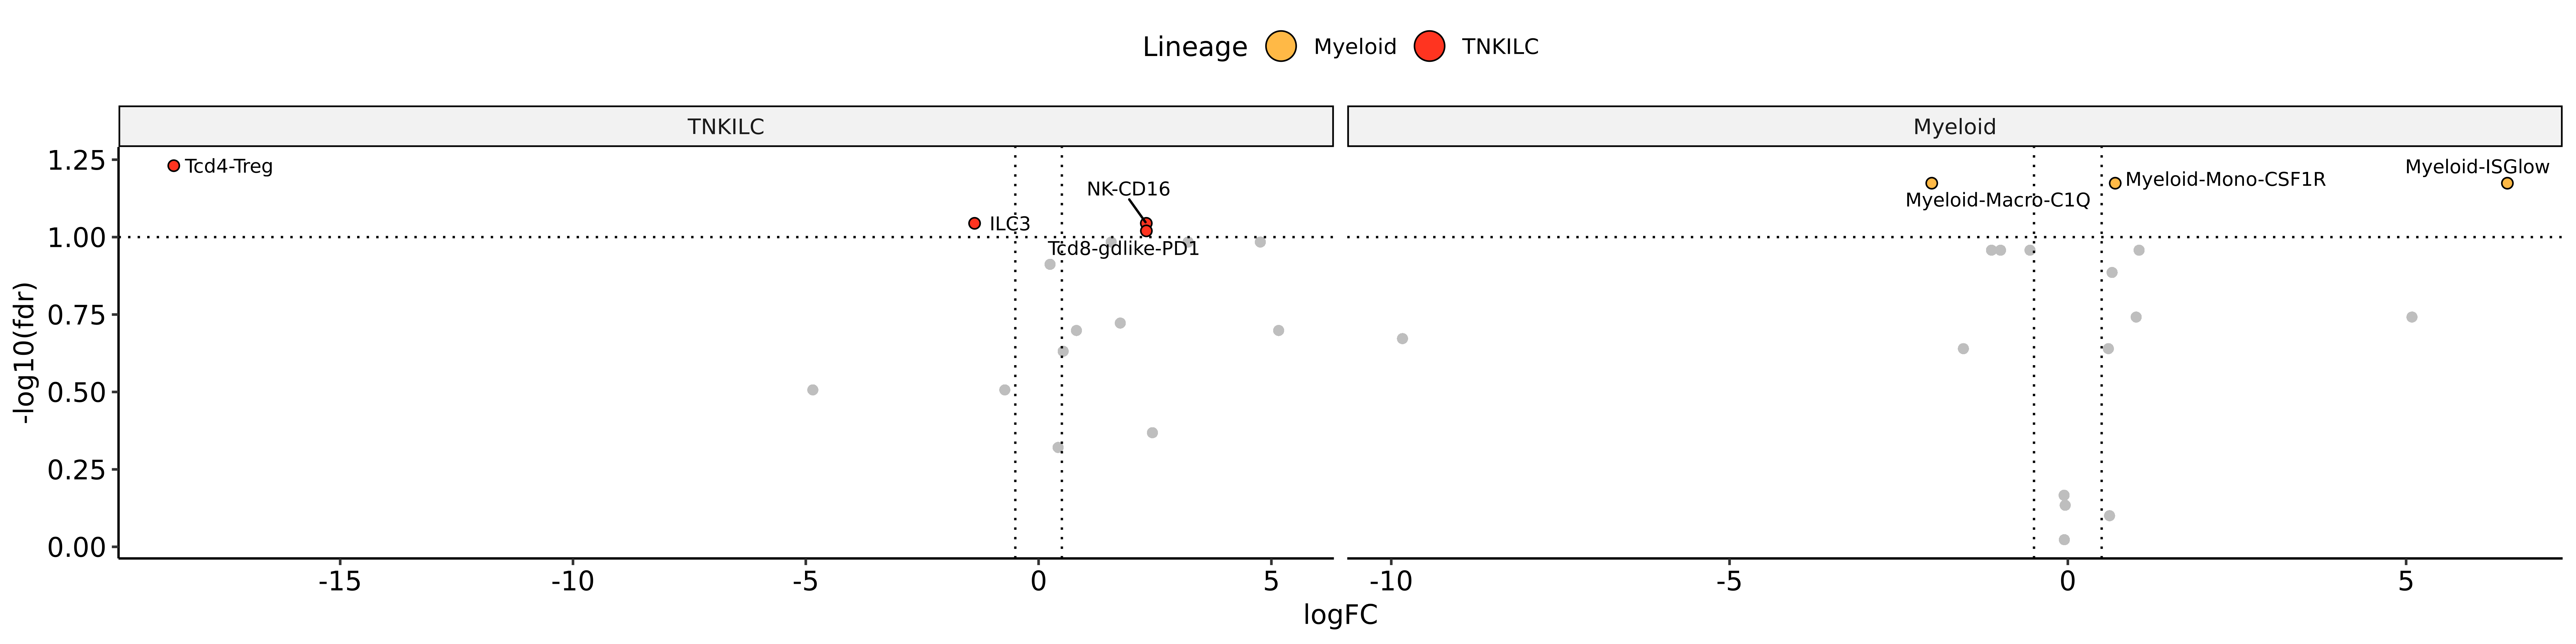

In [25]:
options(repr.plot.width = 16, repr.plot.height = 4, repr.plot.res = 500)
require(ggrepel)
logFC_threshold = 0.5
fdr_threshold = 0.1
.data = percent_of_group %>%
    filter(group == 'MSI') %>%
    mutate(`Significance` = ifelse(
        logFC > logFC_threshold & fdr < fdr_threshold, 
            yes = 'Up in MSI', 
            no = ifelse(
                logFC < -logFC_threshold & fdr < fdr_threshold,
                yes = 'Down in MSI',
                no = 'Not significant'
            ))) %>%
    left_join(., metadata %>% select(knn_coarse, knn_renamed_cell_states) %>% distinct) %>%
    mutate(knn_coarse = ifelse(grepl(knn_renamed_cell_states, pattern = 'Fibro'), 'Strom', knn_coarse)) %>%
    mutate(KNN_group = factor(KNN_group, levels = c('TNKILC', 'Myeloid')))

fig2f_all_volcano = ggplot() + 
    geom_point(data = .data, aes(x = logFC, 
                   y = -log10(fdr)), color = 'grey', size = 2, shape = 16) +
    geom_point(data = .data %>% filter(Significance != 'Not significant'),
               aes(x = logFC, 
                   y = -log10(fdr), 
                   color =  knn_coarse, fill = knn_coarse), size = 2, shape = 21, color = 'black') +
    geom_text_repel(size = 3, 
                    data = .data %>% filter(Significance != 'Not significant'),
                     aes(x = logFC, 
                         y = -log10(fdr),
                         label = knn_renamed_cell_states,), 
                     max.overlaps = Inf, color = 'black',
                         force = 30, hjust = 1) +
    geom_vline(xintercept = logFC_threshold, linetype = 'dotted') +
    geom_vline(xintercept = -logFC_threshold, linetype = 'dotted') +
    geom_hline(yintercept = -log10(fdr_threshold), linetype = 'dotted') + 
    ggpubr::theme_pubr() +
    scale_fill_manual(name = 'Lineage', values = c('Epi' = '#CA49FC',
            'Strom' = '#00D2D0',
            'Myeloid' = '#FFB946',
            'Mast' = '#F4ED57',
            'Plasma' = '#61BDFC',
            'B' = '#0022FA',
            'TNKILC' = '#FF3420'
            )) +
    facet_grid(~KNN_group, scales = 'free', space = 'fixed') +
    guides(fill = guide_legend(override.aes = list(size=6))) +
    NULL
fig2f_all_volcano

## wilcox

## by group

In [ ]:
require(presto)

percent_of_group = lapply(c('Immune', 'Fibroblast', 'Endothelial'), function(groupName){
    .temp2 = .temp %>% filter(KNN_Grouped == groupName) %>% na.omit
    .counts = .temp2 %>%
        ungroup %>%
        select(orig.ident, knn_renamed_cell_states, cell_state_percent_of_group) %>%
        pivot_wider(names_from = knn_renamed_cell_states, values_from = cell_state_percent_of_group, values_fill = 0) %>%
        tibble::column_to_rownames('orig.ident') %>%
        t
    .metadata = .temp2 %>%
        ungroup %>%
        select(orig.ident, condition) %>%
        distinct %>%
        as.data.frame() 
    rownames(.metadata) = .metadata$orig.ident
    .metadata = .metadata[colnames(.counts),]
    return(wilcoxauc(X = .counts, y = .metadata$condition) %>% mutate(KNN_group = groupName))
}) %>% rbindlist
percent_of_group

In [ ]:
percent_of_group$fdr = percent_of_group$padj
percent_of_group$knn_renamed_cell_states = percent_of_group$feature

In [ ]:
# percent_of_group %>% fwrite('figure_2f_raw.csv')

In [ ]:
head(percent_of_group)

In [ ]:
#percent_of_group = fread('figure_2f_raw.csv')

In [ ]:
options(repr.plot.width = 16, repr.plot.height = 4, repr.plot.res = 500)
require(ggrepel)
logFC_threshold = 0.5
fdr_threshold = 0.1
.data = percent_of_group %>%
    filter(group == 'MSI') %>%
    mutate(`Significance` = ifelse(
        logFC > logFC_threshold & fdr < fdr_threshold, 
            yes = 'Up in MSI', 
            no = ifelse(
                logFC < -logFC_threshold & fdr < fdr_threshold,
                yes = 'Down in MSI',
                no = 'Not significant'
            ))) %>%
    left_join(., metadata %>% select(knn_coarse, knn_renamed_cell_states) %>% distinct) %>%
    mutate(knn_coarse = ifelse(grepl(knn_renamed_cell_states, pattern = 'Fibro'), 'Strom', knn_coarse)) %>%
    mutate(KNN_group = factor(KNN_group, levels = c('Immune', 'Fibroblast', 'Endothelial')))

fig2f_all_volcano = ggplot() + 
    geom_point(data = .data, aes(x = logFC, 
                   y = -log10(fdr)), color = 'grey', size = 2, shape = 16) +
    geom_point(data = .data %>% filter(Significance != 'Not significant'),
               aes(x = logFC, 
                   y = -log10(fdr), 
                   color =  knn_coarse, fill = knn_coarse), size = 2, shape = 21, color = 'black') +
    geom_text_repel(size = 3, 
                    data = .data %>% filter(Significance != 'Not significant'),
                     aes(x = logFC, 
                         y = -log10(fdr),
                         label = knn_renamed_cell_states,), 
                     max.overlaps = Inf, color = 'black',
                         force = 30, hjust = 1) +
    geom_vline(xintercept = logFC_threshold, linetype = 'dotted') +
    geom_vline(xintercept = -logFC_threshold, linetype = 'dotted') +
    geom_hline(yintercept = -log10(fdr_threshold), linetype = 'dotted') + 
    ggpubr::theme_pubr() +
    scale_fill_manual(name = 'Lineage', values = c('Epi' = '#CA49FC',
            'Strom' = '#00D2D0',
            'Myeloid' = '#FFB946',
            'Mast' = '#F4ED57',
            'Plasma' = '#61BDFC',
            'B' = '#0022FA',
            'TNKILC' = '#FF3420'
            )) +
    facet_wrap(~KNN_group, scales = 'free', space = 'fixed', nrow = 1) +
    guides(fill = guide_legend(override.aes = list(size=6))) +
    NULL
fig2f_all_volcano
fig2f_all_volcano %>% ggsave(filename = 'figs/fig2f_all_volcano.pdf', height = 4, width = 16, units = 'in')
fig2f_all_volcano %>% ggsave(filename = 'figs/fig2f_all_volcano.png', height = 4, width = 16, units = 'in', dpi = 500)

In [ ]:
options(repr.plot.width = 6, repr.plot.height = 6, repr.plot.res = 500)
require(ggrepel)
logFC_threshold = 0.5
fdr_threshold = 0.1
.data = percent_of_group %>%
    filter(group == 'MSI') %>%
    mutate(`Significance` = ifelse(
        logFC > logFC_threshold & fdr < fdr_threshold, 
            yes = 'Up in MSI', 
            no = ifelse(
                logFC < -logFC_threshold & fdr < fdr_threshold,
                yes = 'Down in MSI',
                no = 'Not significant'
            ))) %>%
    left_join(., metadata %>% select(knn_coarse, knn_renamed_cell_states) %>% distinct) %>%
    mutate(knn_coarse = ifelse(grepl(knn_renamed_cell_states, pattern = 'Fibro'), 'Strom', knn_coarse)) %>%
    mutate(KNN_group = factor(KNN_group, levels = c('Immune', 'Fibroblast', 'Endothelial'))) %>%
    filter(KNN_group == 'Immune')

fig2f = ggplot() + 
    geom_point(data = .data, aes(x = logFC, 
                   y = -log10(fdr)), color = 'grey', size = 2, shape = 16) +
    geom_point(data = .data %>% filter(Significance != 'Not significant'),
               aes(x = logFC, 
                   y = -log10(fdr), 
                   color =  knn_coarse, fill = knn_coarse), size = 2, shape = 21, color = 'black') +
    geom_text_repel(size = 3, 
                    data = .data %>% filter(Significance != 'Not significant'),
                     aes(x = logFC, 
                         y = -log10(fdr),
                         label = knn_renamed_cell_states,), 
                     max.overlaps = Inf, color = 'black',
                         force = 30, hjust = 1) +
    geom_vline(xintercept = logFC_threshold, linetype = 'dotted') +
    geom_vline(xintercept = -logFC_threshold, linetype = 'dotted') +
    geom_hline(yintercept = -log10(fdr_threshold), linetype = 'dotted') + 
    ggpubr::theme_pubr() +
    scale_fill_manual(name = 'Lineage', values = c('Epi' = '#CA49FC',
            'Strom' = '#00D2D0',
            'Myeloid' = '#FFB946',
            'Mast' = '#F4ED57',
            'Plasma' = '#61BDFC',
            'B' = '#0022FA',
            'TNKILC' = '#FF3420'
            )) +
    facet_wrap(~KNN_group, scales = 'free', space = 'fixed', nrow = 1) +
    guides(fill = guide_legend(override.aes = list(size=6))) +
    NULL
fig2f
fig2f %>% ggsave(filename = 'figs/fig2f_immune_volcano.pdf', height = 6, width = 6, units = 'in')
fig2f %>% ggsave(filename = 'figs/fig2f_immune_volcano.png', height = 6, width = 6, units = 'in', dpi = 500)

To confirm that core differences between MMRd and MMRp CRC were still recapitulated in the current cohort despite our enrichment for anti-tumor immunity hub containing tumor specimens, we next compared the immune and stromal composition of MMRd and MMRp tumor regions. Consistent with our previous findings1, putative tumor-reactive CXCL13+ CD4+ and CD8+ T cells(Oliveira et al. 2022; Oliveira et al. 2021; Lowery et al. 2022; Caushi et al. 2021) as well as PDCD1+ gamma delta-like T cells were significantly enriched in MMRd tumors as a fraction of all immune cells (Fig. 1E, Supp Table x). Two additional T/NK cell populations, namely a CD8+ T cell cluster characterized by high expression of ZNF683 (encodes the transcription factor HOBIT) and without obvious counterpart in our prior scRNA-seq study, and CD16+ NK cells ( which were not significantly different between MMRd and MMRp in our prior analysis) were enriched in the MMRd tumor regions. In contrast, mast cells, DC2 subsets, myeloid cells expressing C1Q, and BMP-producing fibroblasts were significantly enriched (statistical test, pvalue) in MMRp CRC, as described previously. Lastly, despite being predicted to participate in anti-tumor immunity hubs, ISG+ myeloid cells were not significantly different between MMRd and MMRp, consistent with our prior analysis, and potentially due to the fact that ISGs can be triggered by innate immune stimuli and type I IFNs outside of IFNg-driven anti-tumor hubs. In sum, we generated a rich data set to spatially map the unique and shared features of MMRd and MMRp CRC, from cell types and states to the multicellular communities they function in.

## supplementary figure 2f

In [ ]:
options(repr.plot.width = 30, repr.plot.height = 30, repr.plot.res = 300)
require(ggpubr)
.pval = percent_of_group %>% 
    left_join(., .temp %>% 
    ungroup %>%
    group_by(KNN_Grouped, knn_renamed_cell_states) %>%
    summarize(maxExpr = max(cell_state_percent_of_group))) %>%
    filter(group == 'MSI') %>%
    select(feature, padj, KNN_group, maxExpr, logFC) %>%
    rename(KNN_Grouped = KNN_group, knn_renamed_cell_states = feature) %>%
    mutate(y.position = maxExpr + 2*abs(logFC)) %>%
    mutate(group1 = 'MSI', group2 = 'MSS') %>%
    mutate(padj = round(padj, digits = 2)) %>%
    filter(KNN_Grouped == 'Immune') 
immune = .temp %>%
    filter(KNN_Grouped == 'Immune') %>%
    ggplot(aes(x = condition, y = cell_state_percent_of_group)) +
        geom_boxplot(aes(x = condition, y = cell_state_percent_of_group), outliers = FALSE) +
        geom_jitter(aes(x = condition, y = cell_state_percent_of_group, color = condition)) +
        facet_wrap(~knn_renamed_cell_states, scales = 'free_y') +
        ggpubr::theme_pubr(base_size = 16) +
        scale_color_manual(name = 'MSI status   ', values = c('MSS' = scales::muted('blue'), 'MSI' = scales::muted('red'))) +
        ylab('Percent of immune cells in region') +
        xlab('\nCondition\n') +
        stat_pvalue_manual(label.size = 8, .pval, label = "fdr = {padj}", tip.length = 0.01, step.increase = 0.1,step.group.by="knn_renamed_cell_states") +
        ggtitle('Immune') +
        theme(axis.title = element_text(size = 20), 
              title = element_text(size = 30), 
              legend.text = element_text(size = 30),
              axis.text.x = element_text(angle = 90, vjust = 0.5, hjust = 0.5)
        ) +
        guides(color = guide_legend(override.aes = list(size = 10))) +
        scale_y_continuous(expand = c(0.2, 0.2)) +
        NULL
.pval = percent_of_group %>% 
    left_join(., .temp %>% 
    ungroup %>%
    group_by(KNN_Grouped, knn_renamed_cell_states) %>%
    summarize(maxExpr = max(cell_state_percent_of_group))) %>%
    filter(group == 'MSI') %>%
    select(feature, padj, KNN_group, maxExpr, logFC) %>%
    rename(KNN_Grouped = KNN_group, knn_renamed_cell_states = feature) %>%
    mutate(y.position = maxExpr + 2*abs(logFC)) %>%
    mutate(group1 = 'MSI', group2 = 'MSS') %>%
    mutate(padj = round(padj, digits = 2)) %>%
    filter(KNN_Grouped == 'Fibroblast') 
fibroblast = .temp %>%
    filter(KNN_Grouped == 'Fibroblast') %>%
    ggplot(aes(x = condition, y = cell_state_percent_of_group)) +
        geom_boxplot(aes(x = condition, y = cell_state_percent_of_group), outliers = FALSE) +
        geom_jitter(aes(x = condition, y = cell_state_percent_of_group, color = condition)) +
        facet_wrap(~knn_renamed_cell_states, scales = 'free_y') +
        ggpubr::theme_pubr(base_size = 16) +
        scale_color_manual(name = 'MSI status   ', values = c('MSS' = scales::muted('blue'), 'MSI' = scales::muted('red'))) +
        ylab('Percent of immune cells in region') +
        xlab('\nCondition\n') +
        stat_pvalue_manual(label.size = 8, .pval, label = "fdr = {padj}", tip.length = 0.01, step.increase = 0.1,step.group.by="knn_renamed_cell_states") +
        ggtitle('Fibroblast') +
        theme(axis.title = element_text(size = 20), 
              title = element_text(size = 30), 
              legend.text = element_text(size = 30),
              axis.text.x = element_text(angle = 90, vjust = 0.5, hjust = 0.5)
        ) +
        guides(color = guide_legend(override.aes = list(size = 10))) +
        scale_y_continuous(expand = c(0.2, 0.2)) +
        NULL

.pval = percent_of_group %>% 
    left_join(., .temp %>% 
    ungroup %>%
    group_by(KNN_Grouped, knn_renamed_cell_states) %>%
    summarize(maxExpr = max(cell_state_percent_of_group))) %>%
    filter(group == 'MSI') %>%
    select(feature, padj, KNN_group, maxExpr, logFC) %>%
    rename(KNN_Grouped = KNN_group, knn_renamed_cell_states = feature) %>%
    mutate(y.position = maxExpr + 2*abs(logFC)) %>%
    mutate(group1 = 'MSI', group2 = 'MSS') %>%
    mutate(padj = round(padj, digits = 2)) %>%
    filter(KNN_Grouped == 'Endothelial') 
endothelial = .temp %>%
    filter(KNN_Grouped == 'Endothelial') %>%
    ggplot(aes(x = condition, y = cell_state_percent_of_group)) +
        geom_boxplot(aes(x = condition, y = cell_state_percent_of_group), outliers = FALSE) +
        geom_jitter(aes(x = condition, y = cell_state_percent_of_group, color = condition)) +
        facet_wrap(~knn_renamed_cell_states, scales = 'free_y') +
        ggpubr::theme_pubr(base_size = 16) +
        scale_color_manual(name = 'MSI status   ', values = c('MSS' = scales::muted('blue'), 'MSI' = scales::muted('red'))) +
        ylab('Percent of immune cells in region') +
        xlab('\nCondition\n') +
        stat_pvalue_manual(label.size = 8, .pval, label = "fdr = {padj}", tip.length = 0.01, step.increase = 0.1,step.group.by="knn_renamed_cell_states") +
        ggtitle('Endothelial') +
        theme(axis.title = element_text(size = 20), 
              title = element_text(size = 30), 
              legend.text = element_text(size = 30),
              axis.text.x = element_text(angle = 90, vjust = 0.5, hjust = 0.5)
        ) +
        guides(color = guide_legend(override.aes = list(size = 10))) +
        scale_y_continuous(expand = c(0.2, 0.2)) +
        NULL

In [ ]:
require(patchwork)
# options(repr.plot.width = 15, repr.plot.height = 23, repr.plot.res = 100)
# fig2f_all_volcano + immune + fibroblast + endothelial + plot_layout(design = 'AA\nBB\nBB\nCD', heights = c(1,2,2,2))

In [ ]:
fig2f_supplementary = wrap_elements(fig2f_all_volcano + immune + fibroblast + endothelial + plot_layout(design = 'AA\nBB\nBB\nCD', heights = c(1,2,2,2)))
fig2f_supplementary %>% ggsave(filename = 'figs/fig2f_supplementary.pdf', height = 45, width = 30, units = 'in')
fig2f_supplementary %>% ggsave(filename = 'figs/fig2f_supplementary.png', height = 45, width = 30, units = 'in', dpi = 500)

## figure 2c - expanded version showing all samples as individual bars

In [ ]:
.temp = pathology_regions %>% 
    left_join(., metadata %>% select(cell_id, orig.ident, area)) %>%
    mutate(orig.ident = gsub(orig.ident, pattern = '_.*', replacement = '')) %>%
    select(condition, orig.ident, KNN_Top, pathology_region, area) %>%
    group_by(orig.ident, condition, KNN_Top, pathology_region) %>%
    summarize(total_cell_state = n(), .groups = 'keep') %>%
    ungroup %>%
    group_by(orig.ident, condition, pathology_region, .drop = FALSE) %>%
    mutate(total_region = sum(total_cell_state)) %>%
    ungroup %>%
    group_by(orig.ident, .drop = FALSE) %>%
    mutate(total_cells = sum(total_cell_state)) %>%
    mutate(cell_state_as_percent_of_total = 100*total_cell_state/total_cells, cell_state_as_percent_of_region = 100*total_cell_state/total_region) %>%
    ungroup %>%
    group_by(pathology_region, KNN_Top) %>%
    na.omit

In [ ]:
options(repr.plot.width = 11, repr.plot.height = 4, repr.plot.res = 200)
fig2c_expanded = ggplot(.temp, aes(x = reorder(orig.ident, -cell_state_as_percent_of_region), y = cell_state_as_percent_of_region, fill = KNN_Top)) +
    geom_bar(position="fill", stat="identity") +
    geom_label(aes(label=scales::scientific(total_region, digits = 2), y = 1), size=3.5, angle = 90, hjust = 1, nudge_x = 0, nudge_y = -0.1, fill = "white", label.size = 0, alpha = 0.1) + 
    facet_grid(.~pathology_region, space = 'free', scales = 'free') +
    ggpubr::theme_pubr(base_size = 12) +
    xlab('Tissue') +
    ylab('Percent of cells in region') +
    theme(axis.text.x = element_text(angle = 90, size = 8)) + #, axis.ticks.x = element_blank()
    scale_fill_manual(name = 'Lineage', values = c('Epi' = '#CA49FC',
'Strom' = '#00D2D0',
'Myeloid' = '#FFB946',
'Mast' = '#F4ED57',
'Plasma' = '#61BDFC',
'B' = '#0022FA',
'TNKILC' = '#FF3420'
)) +
    scale_y_continuous(name = "Percent of cells in region", labels = scales::label_percent(accuracy = 1))
fig2c_expanded

In [ ]:
#ggsave(filename = 'fig2c_expanded.pdf', plot = fig2c, width = 11, height = 4, units = 'in')

# figure 2c: condensed version

In [ ]:
.temp %>%
    group_by(pathology_region, KNN_Top) %>%
    summarize(cell_state_as_percent_of_region = mean(cell_state_as_percent_of_region))

In [ ]:
options(repr.plot.width = 7, repr.plot.height = 7, repr.plot.res = 500)
fig2c_condensed =  .temp %>%
    group_by(pathology_region, KNN_Top) %>%
    summarize(cell_state_as_percent_of_region = mean(cell_state_as_percent_of_region)) %>%
    filter(pathology_region != 'Unannotated') %>%
    mutate(pathology_region = str_wrap(pathology_region, 8)) %>%
    ggplot(., aes(x = pathology_region, 
                  y = cell_state_as_percent_of_region, 
                  fill = KNN_Top)) +
    geom_bar(position="fill", 
             stat="identity") +
    ggpubr::theme_pubr(base_size = 16) +
    theme(legend.position = 'right') +
    xlab('Tissue') +
    ylab('Median percent of cells in region') +
    theme(axis.text.x = element_text(angle = 90, size = 16, vjust = 0.5, hjust = 0.5)) + #, axis.ticks.x = element_blank()
    scale_fill_manual(name = 'Lineage', values = c('Epi' = '#CA49FC',
        'Strom' = '#00D2D0',
        'Myeloid' = '#FFB946',
        'Mast' = '#F4ED57',
        'Plasma' = '#61BDFC',
        'B' = '#0022FA',
        'TNKILC' = '#FF3420'
    )) +
    scale_y_continuous(name = "Median percent of cells in region", labels = scales::label_percent(accuracy = 1))
fig2c_condensed

In [ ]:
#ggsave(filename = 'fig2c_condensed.pdf', plot = fig2c_condensed, width = 7, height = 7, units = 'in')

## figure 2a. Show cell lineages and cell regions for representative sample

## G4595

In [ ]:
require(scattermore)
g4669 = metadata %>% filter(orig.ident %>% grepl(pattern = "G4595")) %>%
    left_join(., pathology_regions %>% select(sample_cell, pathology_region) %>% rename(cell = sample_cell))
table(g4669$pathology_region) %>% as.data.frame %>% filter(Freq > 0)
fig2a_2 = ggplot(g4669) +
    geom_scattermore(aes(x = x, y = y, color = pathology_region)) +
    coord_sf() +
    theme_void() +
    theme(legend.position = 'top') +
    scale_color_manual(name = 'Annotated tissue regions ', 
        values = c('Tumor' = '#91a8d4',
            'Tumor inv-border' = '#0080c0',
            'Tumor lum-border' = '#402a6a',
            'Non-neo. muc.' = '#ffd667',
            'Non-neoplastic submucosa' = '#d8d8d8',
            'M.propria' = '#8d587d',
            'Lymphoid Structure' = '#f19341'
            ), na.value = '#d8d8d8', breaks = c('Tumor',
            'Non-neo. muc.',
            'Tumor inv-border',
            'Tumor lum-border',
            'Lymphoid Structure', 'M.propria'
            )) +
    #ggtitle('Annotated tissue regions') +
    #guides(color=guide_legend(nrow=2,byrow=TRUE)) +
    guides(color = guide_legend(title.position="top", title.hjust = 0.5, ncol = 2))
fig2a_3 = ggplot(g4669) +
    geom_scattermore(aes(x = x, y = y, color = knn_coarse)) +
    coord_sf() +
    theme_void() +
    scale_color_manual(name = 'Cell Lineage ', values = c('Epi' = '#CA49FC',
        'Strom' = '#00D2D0',
        'Myeloid' = '#FFB946',
        'Mast' = '#F4ED57',
        'Plasma' = '#61BDFC',
        'B' = '#0022FA',
        'TNKILC' = '#FF3420'
        )) +
    #ggtitle('Cell Lineage') +
    theme(legend.position = 'top') +
    guides(color = guide_legend(title.position="top", title.hjust = 0.5, ncol = 3))
require(patchwork)
fig2a_G4738_Beta10_08 = plot_spacer() + (fig2a_2 + theme(plot.margin = unit(c(0,30,0,0), "pt"))) + (fig2a_3 + theme(plot.margin = unit(c(0,30,0,0), "pt")))
#ggsave(filename = 'fig2a_G4595.pdf', plot = fig2a_G4738_Beta10_08, width = 9, height = 5)
fig2a_G4738_Beta10_08

## G4738_Beta10_08

In [ ]:
require(scattermore)
g4669 = metadata %>% filter(orig.ident %>% grepl(pattern = "G4738_Beta10_08")) %>%
    left_join(., pathology_regions %>% select(sample_cell, pathology_region) %>% rename(cell = sample_cell))
table(g4669$pathology_region) %>% as.data.frame %>% filter(Freq > 0)
fig2a_2 = ggplot(g4669) +
    geom_scattermore(aes(x = x, y = y, color = pathology_region)) +
    coord_sf() +
    theme_void() +
    theme(legend.position = 'top') +
    scale_color_manual(name = 'Annotated tissue regions ', 
        values = c('Tumor' = '#91a8d4',
            'Tumor inv-border' = '#0080c0',
            'Tumor lum-border' = '#402a6a',
            'Non-neo. muc.' = '#ffd667',
            'Non-neoplastic submucosa' = '#d8d8d8',
            'M.propria' = '#8d587d',
            'Lymphoid Structure' = '#f19341'
            ), na.value = '#d8d8d8', breaks = c('Tumor',
            'Non-neo. muc.',
            'Tumor inv-border',
            'Tumor lum-border',
            'Lymphoid Structure', 'M.propria'
            )) +
    #ggtitle('Annotated tissue regions') +
    #guides(color=guide_legend(nrow=2,byrow=TRUE)) +
    guides(color = guide_legend(title.position="top", title.hjust = 0.5, ncol = 2))
fig2a_3 = ggplot(g4669) +
    geom_scattermore(aes(x = x, y = y, color = knn_coarse)) +
    coord_sf() +
    theme_void() +
    scale_color_manual(name = 'Cell Lineage ', values = c('Epi' = '#CA49FC',
        'Strom' = '#00D2D0',
        'Myeloid' = '#FFB946',
        'Mast' = '#F4ED57',
        'Plasma' = '#61BDFC',
        'B' = '#0022FA',
        'TNKILC' = '#FF3420'
        )) +
    #ggtitle('Cell Lineage') +
    theme(legend.position = 'top') +
    guides(color = guide_legend(title.position="top", title.hjust = 0.5, ncol = 3))
require(patchwork)
fig2a_G4738_Beta10_08 = plot_spacer() + (fig2a_2 + theme(plot.margin = unit(c(0,30,0,0), "pt"))) + (fig2a_3 + theme(plot.margin = unit(c(0,30,0,0), "pt")))
#ggsave(filename = 'fig2a_G4738_Beta10_08.pdf', plot = fig2a_G4738_Beta10_08, width = 9, height = 5)
fig2a_G4738_Beta10_08

## G4738_Beta10_06

In [ ]:
require(scattermore)
g4669 = metadata %>% filter(orig.ident %>% grepl(pattern = "G4738_Beta10_06")) %>%
    left_join(., pathology_regions %>% select(sample_cell, pathology_region) %>% rename(cell = sample_cell))
table(g4669$pathology_region) %>% as.data.frame %>% filter(Freq > 0)
fig2a_2 = ggplot(g4669) +
    geom_scattermore(aes(x = x, y = y, color = pathology_region)) +
    coord_sf() +
    theme_void() +
    theme(legend.position = 'top') +
    scale_color_manual(name = 'Annotated tissue regions ', 
        values = c('Tumor' = '#91a8d4',
            'Tumor inv-border' = '#0080c0',
            'Tumor lum-border' = '#402a6a',
            'Non-neo. muc.' = '#ffd667',
            'Non-neoplastic submucosa' = '#d8d8d8',
            'M.propria' = '#8d587d',
            'Lymphoid Structure' = '#f19341'
            ), na.value = '#d8d8d8', breaks = c('Tumor',
            'Non-neo. muc.',
            'Tumor inv-border',
            'Tumor lum-border',
            'Lymphoid Structure', 'M.propria'
            )) +
    #ggtitle('Annotated tissue regions') +
    #guides(color=guide_legend(nrow=2,byrow=TRUE)) +
    guides(color = guide_legend(title.position="top", title.hjust = 0.5, ncol = 2))
fig2a_3 = ggplot(g4669) +
    geom_scattermore(aes(x = x, y = y, color = knn_coarse)) +
    coord_sf() +
    theme_void() +
    scale_color_manual(name = 'Cell Lineage ', values = c('Epi' = '#CA49FC',
        'Strom' = '#00D2D0',
        'Myeloid' = '#FFB946',
        'Mast' = '#F4ED57',
        'Plasma' = '#61BDFC',
        'B' = '#0022FA',
        'TNKILC' = '#FF3420'
        )) +
    #ggtitle('Cell Lineage') +
    theme(legend.position = 'top') +
    guides(color = guide_legend(title.position="top", title.hjust = 0.5, ncol = 3))
require(patchwork)
fig2a_G4738_Beta10_06 = plot_spacer() + (fig2a_2 + theme(plot.margin = unit(c(0,30,0,0), "pt"))) + (fig2a_3 + theme(plot.margin = unit(c(0,30,0,0), "pt")))
#ggsave(filename = 'fig2a_G4738_Beta10_06.pdf', plot = fig2a_G4738_Beta10_06, width = 9, height = 5)
fig2a_G4738_Beta10_06

## G4669_reg1

In [ ]:
require(scattermore)
options(repr.plot.width = 4, repr.plot.height = 4, repr.plot.res = 500)
g4669 = metadata %>% filter(orig.ident %>% grepl(pattern = "G4669_reg1")) %>%
    left_join(., pathology_regions %>% select(sample_cell, pathology_region) %>% rename(cell = sample_cell))
table(g4669$pathology_region) %>% as.data.frame %>% filter(Freq > 0)
fig2a_g4669_2 = ggplot(g4669) +
    geom_scattermore(aes(x = x, y = y, color = pathology_region)) +
    coord_sf() +
    theme_void() +
    theme(legend.position = 'top') +
    scale_color_manual(name = 'Annotated tissue regions ', 
        values = c('Tumor' = '#91a8d4',
            'Tumor inv-border' = '#0080c0',
            'Tumor lum-border' = '#402a6a',
            'Non-neo. muc.' = '#ffd667',
            'Non-neoplastic submucosa' = '#d8d8d8',
            'M.propria' = '#8d587d',
            'Lymphoid Structure' = '#f19341'
            ), na.value = '#d8d8d8', breaks = c('Tumor',
            'Non-neo. muc.',
            'Tumor inv-border',
            'Tumor lum-border',
            'Lymphoid Structure', 'M.propria'
            )) +
    #ggtitle('Annotated tissue regions') +
    #guides(color=guide_legend(nrow=2,byrow=TRUE)) +
    guides(color = guide_legend(title.position="top", title.hjust = 0.5, ncol = 2))
fig2a_g4669_3 = ggplot(g4669) +
    geom_scattermore(aes(x = x, y = y, color = knn_coarse)) +
    coord_sf() +
    theme_void() +
    scale_color_manual(name = 'Cell Lineage ', values = c('Epi' = '#CA49FC',
        'Strom' = '#00D2D0',
        'Myeloid' = '#FFB946',
        'Mast' = '#F4ED57',
        'Plasma' = '#61BDFC',
        'B' = '#0022FA',
        'TNKILC' = '#FF3420'
        )) +
    #ggtitle('Cell Lineage') +
    theme(legend.position = 'top') +
    guides(color = guide_legend(title.position="top", title.hjust = 0.5, ncol = 3))
require(patchwork)
fig2a_g4669 = plot_spacer() + (fig2a_g4669_2 + theme(plot.margin = unit(c(0,30,0,0), "pt"))) + (fig2a_g4669_3 + theme(plot.margin = unit(c(0,30,0,0), "pt")))
#ggsave(filename = 'fig2a_g4669.pdf', plot = fig2a_g4669, width = 9, height = 5)
fig2a_g4669

## G4423

In [ ]:
require(scattermore)
g4669 = metadata %>% filter(orig.ident %>% grepl(pattern = "G4423")) %>%
    left_join(., pathology_regions %>% select(sample_cell, pathology_region) %>% rename(cell = sample_cell)) %>%
    mutate(pathology_region = gsub(pathology_region, pattern = '_', replacement = ' '))
table(g4669$pathology_region) %>% as.data.frame %>% filter(Freq > 0)
fig2a_2 = ggplot(g4669) +
    geom_scattermore(aes(x = x, y = y, color = pathology_region)) +
    coord_sf() +
    theme_void() +
    theme(legend.position = 'top') +
    scale_color_manual(name = 'Annotated tissue regions ', 
        values = c('Tumor' = '#91a8d4',
            'Tumor inv-border' = '#0080c0',
            'Tumor lum-border' = '#402a6a',
            'Non-neo. muc.' = '#ffd667',
            #'Non-neoplastic submucosa' = '#d8d8d8',
            'M.propria' = '#8d587d',
            'Lymphoid Structure' = '#f19341'
            ), na.value = '#d8d8d8', breaks = c('Tumor',
            'Non-neo. muc.', 'Tumor inv-border', 'Tumor lum-border',
            'Lymphoid Structure', 'M.propria'
            )) +
    #ggtitle('Annotated tissue regions') +
    #guides(color=guide_legend(nrow=2,byrow=TRUE)) +
    guides(color = guide_legend(title.position="top", title.hjust = 0.5, ncol = 2))
fig2a_3 = ggplot(g4669) +
    geom_scattermore(aes(x = x, y = y, color = knn_coarse)) +
    coord_sf() +
    theme_void() +
    scale_color_manual(name = 'Cell Lineage ', values = c('Epi' = '#CA49FC',
        'Strom' = '#00D2D0',
        'Myeloid' = '#FFB946',
        'Mast' = '#F4ED57',
        'Plasma' = '#61BDFC',
        'B' = '#0022FA',
        'TNKILC' = '#FF3420'
        )) +
    #ggtitle('Cell Lineage') +
    theme(legend.position = 'top') +
    guides(color = guide_legend(title.position="top", title.hjust = 0.5, ncol = 3))
require(patchwork)
fig2a_g4423 = plot_spacer() + (fig2a_2 + theme(plot.margin = unit(c(0,30,0,0), "pt"))) + (fig2a_3 + theme(plot.margin = unit(c(0,30,0,0), "pt")))
#ggsave(filename = 'fig2a_g4423.pdf', plot = fig2a_g4423, width = 9, height = 5)
fig2a_g4423

## C164

In [ ]:
require(scattermore)
g4669 = metadata %>% filter(orig.ident %>% grepl(pattern = "C164")) %>%
    left_join(., pathology_regions %>% select(sample_cell, pathology_region) %>% rename(cell = sample_cell)) %>%
    mutate(pathology_region = gsub(pathology_region, pattern = '_', replacement = ' '))
table(g4669$pathology_region) %>% as.data.frame %>% filter(Freq > 0)
fig2a_2 = ggplot(g4669) +
    geom_scattermore(aes(x = x, y = y, color = pathology_region)) +
    coord_sf() +
    theme_void() +
    theme(legend.position = 'top') +
    scale_color_manual(name = 'Annotated tissue regions ', 
        values = c('Tumor' = '#91a8d4',
            'Tumor inv-border' = '#0080c0',
            'Tumor lum-border' = '#402a6a',
            'Non-neo. muc.' = '#ffd667',
            #'Non-neoplastic submucosa' = '#d8d8d8',
            'M.propria' = '#8d587d',
            'Lymphoid Structure' = '#f19341'
            ), na.value = '#d8d8d8', breaks = c('Tumor',
            'Non-neo. muc.', 'Tumor inv-border', 'Tumor lum-border',
            'Lymphoid Structure', 'M.propria'
            )) +
    #ggtitle('Annotated tissue regions') +
    #guides(color=guide_legend(nrow=2,byrow=TRUE)) +
    guides(color = guide_legend(title.position="top", title.hjust = 0.5, ncol = 2))
fig2a_3 = ggplot(g4669) +
    geom_scattermore(aes(x = x, y = y, color = knn_coarse)) +
    coord_sf() +
    theme_void() +
    scale_color_manual(name = 'Cell Lineage ', values = c('Epi' = '#CA49FC',
        'Strom' = '#00D2D0',
        'Myeloid' = '#FFB946',
        'Mast' = '#F4ED57',
        'Plasma' = '#61BDFC',
        'B' = '#0022FA',
        'TNKILC' = '#FF3420'
        )) +
    #ggtitle('Cell Lineage') +
    theme(legend.position = 'top') +
    guides(color = guide_legend(title.position="top", title.hjust = 0.5, ncol = 3))
require(patchwork)
fig2a_c164 = plot_spacer() + (fig2a_2 + theme(plot.margin = unit(c(0,30,0,0), "pt"))) + (fig2a_3 + theme(plot.margin = unit(c(0,30,0,0), "pt")))
#ggsave(filename = 'fig2a_c164.pdf', plot = fig2a_c164, width = 9, height = 5)
fig2a_c164

## figure 2b

In [ ]:
dim(metadata)
dim(pathology_regions)
dim(pathology_regions_preQC)

In [ ]:
total_cells = metadata %>% 
    group_by(orig.ident) %>% 
    summarize(total_cells = n()) %>%
    mutate(orig.ident = gsub(orig.ident, pattern = "_.*", replacement = "")) %>%
    group_by(orig.ident) %>% 
    summarize(total_cells = sum(total_cells))
total_cells

In [ ]:
.temp = pathology_regions %>% 
    left_join(., metadata %>% select(cell_id, orig.ident, area)) %>%
    mutate(orig.ident = gsub(orig.ident, pattern = '_.*', replacement = '')) %>%
    select(condition, orig.ident, pathology_region, area) %>%
    group_by(orig.ident, condition, pathology_region) %>%
    summarize(total_cells_in_region = n(), .groups = 'keep') %>%
    ungroup %>%
    group_by(orig.ident, .groups = 'keep') %>%
    #mutate(total_cells = sum(total_cells_in_region)) %>%
    left_join(., total_cells) %>%
    ungroup %>%
    mutate(region_as_percent_of_total = 100*total_cells_in_region/total_cells) %>%
    ungroup %>%
    #na.omit %>% # 25-Feb-01: Jon says to keep these unannotated regions as a grey region in the barplot
    mutate(condition = ifelse(condition == 'MSI', 'MMRd', 'MMRp')) %>%
    mutate(condition = as.factor(condition)) %>%
    arrange(condition, desc(total_cells)) %>%
    mutate(orig.ident = factor(orig.ident)) 
.temp

In [ ]:
table(.temp$pathology_region, useNA = 'always')
pathology_regions$pathology_region %>% unique

In [ ]:
ordered_idents = .temp %>% select(orig.ident, condition, total_cells) %>% distinct %>% group_by(condition) %>% slice_max(order_by = total_cells, n = nrow(.)) %>% ungroup %>% mutate(orig.ident = as.vector(orig.ident)) %>% pull(orig.ident)
ordered_idents

In [ ]:
require(scales)
ggplot(.temp %>% select(orig.ident, condition, total_cells) %>% distinct) +
    geom_col(aes(x = reorder(orig.ident, desc(total_cells)), y = total_cells, fill = condition)) +
    facet_grid(~condition, scales = 'free', space = 'free') +
    ggpubr::theme_pubr() +
    theme(axis.text.x = element_text(angle = 90, size = 8),
          strip.background = element_blank(),
          strip.text.x = element_blank()) +
    scale_fill_manual(name =  'MMR status ', values = c('MMRd' = muted("red"), 'MMRp' = muted("blue"))) +
    xlab('Specimen') +
    ylab('Total number of cells')

In [ ]:
require(scales)
fig2b_1 = ggplot(.temp %>% select(orig.ident, condition, total_cells) %>% distinct %>% mutate(orig.ident = factor(orig.ident, levels = ordered_idents))) +
    geom_col(aes(x = orig.ident, y = total_cells, fill = condition)) +
    #facet_grid(~condition, scales = 'free', space = 'free') +
    ggpubr::theme_pubr() +
    theme(axis.text.x = element_text(angle = 90, size = 8),
          strip.background = element_blank(),
          strip.text.x = element_blank()) +
    scale_fill_manual(name =  'MMR status   ', values = c('MMRd' = muted("red"), 'MMRp' = muted("blue"))) +
    xlab('Specimen') +
    ylab('Number of cells\n') +
    geom_hline(yintercept = median(.temp$total_cells), linetype = 'dashed') +
    geom_hline(yintercept = max(.temp$total_cells), linetype = 'dashed') +
    scale_y_continuous(breaks = c(0, 4e5, 9e5)) + #round(mean(.temp$total_cells)), round(max(.temp$total_cells)))) +
    theme(legend.position = 'right') +
    NULL
fig2b_1

In [ ]:
options(repr.plot.width = 12, repr.plot.height = 5, repr.plot.res = 200)
fig2b_2 = ggplot(.temp %>% mutate(orig.ident = factor(orig.ident, levels = ordered_idents)), 
    aes(x = orig.ident, y = region_as_percent_of_total, fill = pathology_region)) +
    geom_bar(position="fill", stat="identity") +
    ggpubr::theme_pubr(base_size = 12) +
    xlab('Tissue') +
    ylab('Percent of cells in region') +
    #geom_label(aes(label=total_cells, y = 1), size=5, angle = 90, hjust = 1, nudge_x = 0, nudge_y = -0.1, fill = "white", label.size = 0, alpha = 0.1) + 
    theme(axis.text.x = element_text(angle = 90, size = 8)) + 
    scale_fill_manual(name = 'Tissue regions    ', 
        values = c('Tumor' = '#91a8d4',
            'Tumor inv-border' = '#0080c0',
            'Tumor lum-border' = '#402a6a',
            'Non-neo. muc.' = '#ffd667',
            'Unannotated' = '#d8d8d8',
            'Non-neoplastic submucosa' = '#d8d8d8',
            'M. propria' = '#8d587d',
            'Lymphoid Structure' = '#f19341'
            ), na.value = '#d8d8d8', breaks = c('Tumor',
            'Non-neo. muc.', 'Tumor inv-border', 'Tumor lum-border',
            'Lymphoid Structure', 'M. propria', 'Unannotated'
            )) +
    scale_y_continuous(name = "Percent of cells in region", labels = scales::label_percent(accuracy = 1)) +
    ggpubr::theme_pubr() +
    theme(axis.text.x = element_text(angle = 90, size = 8)) + #, legend.key.spacing.x = unit(0.75, "cm"), legend.title.position = 'left') +
    theme(legend.position = 'right') +
    NULL
fig2b_2

In [ ]:
options(repr.plot.width = 11, repr.plot.height = 6, repr.plot.res = 200)
fig2b = (fig2b_1 + theme(axis.text.x = element_blank()) + xlab('')) + fig2b_2 + plot_layout(nrow = 2, heights = c(1, 2.5), guides = 'collect')
fig2b

In [ ]:
#ggsave(filename = 'fig2b.pdf', plot = fig2b, width = 11, height = 6)

## figure 2d and e - volcano plots showing enrichment of cell states and their densities in Tumor regions

## glmms

In [ ]:
.temp = pathology_regions %>% 
    left_join(., metadata %>% select(cell_id, orig.ident, area)) %>%
    mutate(orig.ident = gsub(orig.ident, pattern = '_.*', replacement = '')) %>%
    select(condition, orig.ident, KNN_Top, knn_renamed_cell_states, pathology_region, area) %>%
    mutate(pathology_region = ifelse(grepl(pathology_region, pattern = 'tumor|Tumor'), 'Tumor', pathology_region)) %>%
    filter(pathology_region %in% c('Tumor', 'Non-neo. muc.')) %>%
    group_by(orig.ident, condition, KNN_Top, knn_renamed_cell_states, pathology_region) %>%
    summarize(total_cell_state = n(), .groups = 'keep') %>%
    ungroup %>%
    group_by(orig.ident, condition, pathology_region, .drop = FALSE) %>%
    mutate(total_region = sum(total_cell_state)) %>%
    ungroup %>%
    group_by(orig.ident, .drop = FALSE) %>%
    mutate(total_cells = sum(total_cell_state)) %>%
    mutate(cell_state_as_percent_of_total = 100*total_cell_state/total_cells, cell_state_as_percent_of_region = 100*total_cell_state/total_region) %>%
    ungroup %>%
    group_by(pathology_region, KNN_Top, knn_renamed_cell_states) %>%
    mutate(pathology_region = gsub(pathology_region, pattern = '_', replacement = ' ')) %>%
    mutate(immune = ifelse(KNN_Top %in% c('B', 'Plasma', 'TNKILC', 'Myeloid', 'Mast'), 'Immune', 'Other')) %>%
    filter(immune == 'Immune') %>%
    filter(pathology_region %in% c('Non-neo. muc.', 'Tumor')) %>%
    mutate(sample_region = paste0(orig.ident, "_", pathology_region))
.temp

In [ ]:
.counts = .temp %>%
    ungroup %>%
    select(sample_region, knn_renamed_cell_states, total_cell_state) %>%
    pivot_wider(names_from = knn_renamed_cell_states, values_from = total_cell_state, values_fill = 0) %>%
    tibble::column_to_rownames('sample_region') %>%
    t
dim(.counts)
.counts

In [ ]:
.metadata = .temp %>%
    ungroup %>%
    mutate(logUMI = log(total_region + 1)) %>%
    select(sample_region, pathology_region, logUMI, orig.ident) %>%
    distinct %>%
    as.data.frame() 
rownames(.metadata) = .metadata$sample_region
.metadata = .metadata[colnames(.counts),]
.metadata

In [ ]:
require(future)
require(furrr)
require(lme4)
require(Matrix)
require(presto)
require(singlecellmethods)

system.time({
presto_res = presto::presto.presto(
    y ~ 1 + (1|pathology_region) + (1|orig.ident) + offset(logUMI), 
    .metadata, 
    .counts,
    size_varname = "logUMI", 
    effects_cov = 'pathology_region',
    ncore = 10, 
    min_sigma = .05,
    family = "poisson",
    nsim = 1000 
)})

contrasts_mat = make_contrast.presto(
    presto_res, 
    var_contrast = 'pathology_region')

effects_marginal = contrasts.presto(
    presto_res, 
    contrasts_mat, 
    one_tailed = FALSE
) %>% 
    dplyr::mutate(
        logFC = sign(beta) * log2(exp(abs(beta))), # convert stats to log2 for interpretability 
        SD = log2(exp(sigma)),
        zscore = logFC / SD,
        fdr = p.adjust(pvalue, method = 'fdr')
    ) %>%
    arrange(pvalue)

effects_marginal

In [ ]:
.effects_marginal = metadata %>%
    select(knn_coarse, knn_renamed_cell_states) %>%
    distinct %>%
    right_join(., effects_marginal, join_by('knn_renamed_cell_states' == 'feature'))
slice_sample(.effects_marginal, n = 10)

In [ ]:
.effects_marginal %>%
    filter(grepl(knn_renamed_cell_states, pattern = 'Myeloid-ISGhigh'))

In [ ]:
options(repr.plot.width = 7, repr.plot.height = 7, repr.plot.res = 200)
require(ggrepel)
logFC_threshold = 1.5
fdr_threshold = 0.05
.data = .effects_marginal %>%
    filter(contrast == 'Tumor') %>%
    mutate(`Significance` = ifelse(
        logFC > logFC_threshold & fdr < fdr_threshold, 
            yes = 'Up in Tumor', 
            no = ifelse(
                logFC < -logFC_threshold & fdr < fdr_threshold,
                yes = 'Down in Tumor',
                no = 'Not significant'
            ))) 
    
    ggplot() + 
        geom_point(data = .data, aes(x = logFC, 
                       y = -log10(fdr)), color = 'grey', size = 4, shape = 16) +
        geom_point(data = .data %>% filter(Significance != 'Not significant'),
                   aes(x = logFC, 
                       y = -log10(fdr), 
                       color =  knn_coarse, fill = knn_coarse), size = 4, shape = 21) +
        geom_label_repel(force = 30, 
                         data = .data %>% filter(Significance != 'Not significant'),
                         aes(x = logFC, 
                             y = -log10(fdr), 
                             #color = knn_coarse, #`pval < 0.05 &\nabs(logFC) > 0.5`, 
                             label = knn_renamed_cell_states), 
                         max.overlaps = Inf, color = 'black') +
        geom_vline(xintercept = logFC_threshold, linetype = 'dotted') +
        geom_vline(xintercept = -logFC_threshold, linetype = 'dotted') +
        geom_hline(yintercept = -log10(fdr_threshold), linetype = 'dotted') + 
        theme_classic(base_size = 16) +
        scale_color_manual(name = 'Lineage', values = c('Epi' = '#CA49FC',
                'Strom' = '#00D2D0',
                'Myeloid' = '#FFB946',
                'Mast' = '#F4ED57',
                'Plasma' = '#61BDFC',
                'B' = '#0022FA',
                'TNKILC' = '#FF3420'
                )) +
        scale_fill_manual(name = 'Lineage', values = c('Epi' = '#CA49FC',
                'Strom' = '#00D2D0',
                'Myeloid' = '#FFB946',
                'Mast' = '#F4ED57',
                'Plasma' = '#61BDFC',
                'B' = '#0022FA',
                'TNKILC' = '#FF3420'
                )) +
        xlim(-3.5, 3.5) + 
        ggtitle('Immune Cells') +
        NULL

In [ ]:
require(future)
require(furrr)
require(lme4)
require(Matrix)
require(presto)
require(singlecellmethods)
all_effects_marginal = matrix(nrow = 1, ncol = 1, data = NA)
# .temp = pathology_regions %>% 
#     left_join(., metadata %>% select(cell_id, orig.ident, area)) %>%
#     mutate(knn_renamed_cell_states = ifelse(knn_renamed_cell_states %in% c('Fibro-CXCL14', 'Fibro-BMP'), 'Fibro-CXCL14-BMP', knn_renamed_cell_states)) %>%
#     mutate(orig.ident = gsub(orig.ident, pattern = '_.*', replacement = '')) %>%
#     select(condition, orig.ident, KNN_Grouped, KNN_Top, knn_renamed_cell_states, pathology_region, area) %>%
#     mutate(pathology_region = ifelse(grepl(pathology_region, pattern = 'tumor|Tumor'), 'Tumor', pathology_region)) %>%
#     filter(pathology_region %in% c('Tumor', 'Non-neo. muc.')) %>%
#     group_by(orig.ident, condition,KNN_Grouped,  KNN_Top, knn_renamed_cell_states, pathology_region) %>%
#     summarize(total_cell_state = n(), .groups = 'keep') %>%
#     ungroup %>%
#     group_by(orig.ident, condition,KNN_Grouped, pathology_region, .drop = FALSE) %>%
#     summarize(total_cells_in_group = sum(total_cell_state), .groups = 'keep') %>%
#     ungroup %>%
#     mutate(fract_of_group = total_cell_state/total_cells_in_group) %>%
#     ungroup %>%
#     group_by(orig.ident, condition, pathology_region, .drop = FALSE) %>%
#     mutate(total_region = sum(total_cell_state)) %>%
#     ungroup %>%
#     group_by(orig.ident, .drop = FALSE) %>%
#     mutate(total_cells = sum(total_cell_state)) %>%
#     mutate(cell_state_as_percent_of_total = 100*total_cell_state/total_cells, cell_state_as_percent_of_region = 100*total_cell_state/total_region) %>%
#     ungroup %>%
#     group_by(pathology_region, KNN_Grouped, KNN_Top, knn_renamed_cell_states) %>%
#     mutate(pathology_region = gsub(pathology_region, pattern = '_', replacement = ' ')) %>%
#     filter(pathology_region %in% c('Non-neo. muc.', 'Tumor')) %>%
#     mutate(sample_region = paste0(orig.ident, "_", pathology_region))
# .temp

In [ ]:
unique(.temp$pathology_region)# %>% length

## wilcox

## by lineage

In [ ]:
.temp = pathology_regions %>% 
    left_join(., metadata %>% select(cell_id, orig.ident, area)) %>%
    mutate(orig.ident = gsub(orig.ident, pattern = '_.*', replacement = '')) %>%
    select(condition, orig.ident, KNN_Top, knn_renamed_cell_states, pathology_region, area) %>%
    mutate(pathology_region = ifelse(grepl(pathology_region, pattern = 'tumor|Tumor'), 'Tumor', pathology_region)) %>%
    filter(pathology_region %in% c('Tumor', 'Non-neo. muc.')) %>%
    group_by(orig.ident, condition, KNN_Top, knn_renamed_cell_states, pathology_region) %>%
    summarize(total_cell_state = n(), .groups = 'keep') %>%
    ungroup %>%
    group_by(orig.ident, condition, KNN_Top, pathology_region, .drop = FALSE) %>%
    mutate(total_cells_in_group = sum(total_cell_state)) %>%
    ungroup %>%
    mutate(percent_of_group = 100*total_cell_state/total_cells_in_group) %>%
    ungroup %>%
    group_by(orig.ident, condition, pathology_region, .drop = FALSE) %>%
    mutate(total_region = sum(total_cell_state)) %>%
    ungroup %>%
    group_by(orig.ident, .drop = FALSE) %>%
    mutate(total_cells = sum(total_cell_state)) %>%
    mutate(cell_state_as_percent_of_total = 100*total_cell_state/total_cells, cell_state_as_percent_of_region = 100*total_cell_state/total_region) %>%
    ungroup %>%
    group_by(pathology_region, KNN_Top, knn_renamed_cell_states) %>%
    mutate(pathology_region = gsub(pathology_region, pattern = '_', replacement = ' ')) %>%
    filter(pathology_region %in% c('Non-neo. muc.', 'Tumor')) %>%
    mutate(sample_region = paste0(orig.ident, "_", pathology_region)) %>%
    ungroup 
.temp %>%
    head

In [ ]:
.temp %>%
    filter()

In [ ]:
require(presto)

percent_of_group = lapply(c('TNKILC', 'Myeloid'), function(groupName){
    .temp2 = .temp %>% filter(KNN_Top == groupName) %>% na.omit
    .counts = .temp2 %>%
        ungroup %>%
        select(sample_region, knn_renamed_cell_states, percent_of_group) %>%
        pivot_wider(names_from = knn_renamed_cell_states, values_from = percent_of_group, values_fill = 0) %>%
        tibble::column_to_rownames('sample_region') %>%
        t
    .metadata = .temp2 %>%
        ungroup %>%
        select(sample_region, pathology_region, orig.ident) %>%
        distinct %>%
        as.data.frame() 
    rownames(.metadata) = .metadata$sample_region
    .metadata = .metadata[colnames(.counts),]
    return(wilcoxauc(X = .counts, y = .metadata$pathology_region) %>% mutate(KNN_group = groupName))
}) %>% rbindlist
percent_of_group$fdr = percent_of_group$padj
percent_of_group$knn_renamed_cell_states = percent_of_group$feature
percent_of_group

In [ ]:
options(repr.plot.width = 11, repr.plot.height = 4, repr.plot.res = 500)
require(ggrepel)
logFC_threshold = 0.5
fdr_threshold = 0.1
.data = percent_of_group %>%
    filter(group == 'Tumor') %>%
    mutate(`Significance` = ifelse(
        logFC > logFC_threshold & fdr < fdr_threshold, 
            yes = 'Up in Tumor', 
            no = ifelse(
                logFC < -logFC_threshold & fdr < fdr_threshold,
                yes = 'Down in Tumor',
                no = 'Not significant'
            ))) %>%
    left_join(., metadata %>% select(knn_coarse, knn_renamed_cell_states) %>% distinct) %>%
    mutate(knn_coarse = ifelse(grepl(knn_renamed_cell_states, pattern = 'Fibro'), 'Strom', knn_coarse)) %>%
    mutate(KNN_group = factor(KNN_group, levels = c('TNKILC', 'Myeloid')))

fig2d = ggplot() + 
    geom_point(data = .data, aes(x = logFC, 
                   y = -log10(fdr)), color = 'grey', size = 2, shape = 16) +
    geom_point(data = .data %>% filter(Significance != 'Not significant'),
               aes(x = logFC, 
                   y = -log10(fdr), 
                   color =  knn_coarse, fill = knn_coarse), size = 2, shape = 21, color = 'black') +
    geom_text_repel(size = 3, 
                    data = .data %>% filter(Significance != 'Not significant'),
                     aes(x = logFC, 
                         y = -log10(fdr),
                         label = knn_renamed_cell_states,), 
                     max.overlaps = Inf, color = 'black',
                         force = 30, hjust = 1) +
    geom_vline(xintercept = logFC_threshold, linetype = 'dotted') +
    geom_vline(xintercept = -logFC_threshold, linetype = 'dotted') +
    geom_hline(yintercept = -log10(fdr_threshold), linetype = 'dotted') + 
    ggpubr::theme_pubr() +
    scale_fill_manual(name = 'Lineage', values = c('Epi' = '#CA49FC',
            'Strom' = '#00D2D0',
            'Myeloid' = '#FFB946',
            'Mast' = '#F4ED57',
            'Plasma' = '#61BDFC',
            'B' = '#0022FA',
            'TNKILC' = '#FF3420'
            )) +
    facet_grid(~KNN_group, scales = 'free', space = 'fixed') +
    guides(fill = guide_legend(override.aes = list(size=6))) +
    NULL
fig2d

## by group

In [ ]:
.temp = pathology_regions %>% 
    left_join(., metadata %>% select(cell_id, orig.ident, area)) %>%
    mutate(orig.ident = gsub(orig.ident, pattern = '_.*', replacement = '')) %>%
    select(condition, orig.ident, KNN_Grouped, KNN_Top, knn_renamed_cell_states, pathology_region, area) %>%
    mutate(pathology_region = ifelse(grepl(pathology_region, pattern = 'tumor|Tumor'), 'Tumor', pathology_region)) %>%
    filter(pathology_region %in% c('Tumor', 'Non-neo. muc.')) %>%
    group_by(orig.ident, condition,KNN_Grouped,  KNN_Top, knn_renamed_cell_states, pathology_region) %>%
    summarize(total_cell_state = n(), .groups = 'keep') %>%
    ungroup %>%
    group_by(orig.ident, condition,KNN_Grouped, pathology_region, .drop = FALSE) %>%
    mutate(total_cells_in_group = sum(total_cell_state)) %>%
    ungroup %>%
    mutate(percent_of_group = 100*total_cell_state/total_cells_in_group) %>%
    ungroup %>%
    group_by(orig.ident, condition, pathology_region, .drop = FALSE) %>%
    mutate(total_region = sum(total_cell_state)) %>%
    ungroup %>%
    group_by(orig.ident, .drop = FALSE) %>%
    mutate(total_cells = sum(total_cell_state)) %>%
    mutate(cell_state_as_percent_of_total = 100*total_cell_state/total_cells, cell_state_as_percent_of_region = 100*total_cell_state/total_region) %>%
    ungroup %>%
    group_by(pathology_region, KNN_Grouped, KNN_Top, knn_renamed_cell_states) %>%
    mutate(pathology_region = gsub(pathology_region, pattern = '_', replacement = ' ')) %>%
    filter(pathology_region %in% c('Non-neo. muc.', 'Tumor')) %>%
    mutate(sample_region = paste0(orig.ident, "_", pathology_region)) %>%
    ungroup 
.temp %>%
    head

In [ ]:
require(presto)

percent_of_group = lapply(c('Immune', 'Fibroblast', 'Endothelial'), function(groupName){
    .temp2 = .temp %>% filter(KNN_Grouped == groupName) %>% na.omit
    .counts = .temp2 %>%
        ungroup %>%
        select(sample_region, knn_renamed_cell_states, percent_of_group) %>%
        pivot_wider(names_from = knn_renamed_cell_states, values_from = percent_of_group, values_fill = 0) %>%
        tibble::column_to_rownames('sample_region') %>%
        t
    .metadata = .temp2 %>%
        ungroup %>%
        select(sample_region, pathology_region, orig.ident) %>%
        distinct %>%
        as.data.frame() 
    rownames(.metadata) = .metadata$sample_region
    .metadata = .metadata[colnames(.counts),]
    return(wilcoxauc(X = .counts, y = .metadata$pathology_region) %>% mutate(KNN_group = groupName))
}) %>% rbindlist
percent_of_group$fdr = percent_of_group$padj
percent_of_group$knn_renamed_cell_states = percent_of_group$feature
percent_of_group

In [ ]:
#percent_of_group %>% fwrite('figure_2d_raw.csv')

In [ ]:
#percent_of_group = fread('figure_2d_raw.csv')

In [ ]:
options(repr.plot.width = 20, repr.plot.height = 4, repr.plot.res = 500)
require(ggrepel)
logFC_threshold = 0.5
fdr_threshold = 0.1
.data = percent_of_group %>%
    filter(group == 'Tumor') %>%
    mutate(`Significance` = ifelse(
        logFC > logFC_threshold & fdr < fdr_threshold, 
            yes = 'Up in Tumor', 
            no = ifelse(
                logFC < -logFC_threshold & fdr < fdr_threshold,
                yes = 'Down in Tumor',
                no = 'Not significant'
            ))) %>%
    left_join(., metadata %>% select(knn_coarse, knn_renamed_cell_states) %>% distinct) %>%
    mutate(knn_coarse = ifelse(grepl(knn_renamed_cell_states, pattern = 'Fibro'), 'Strom', knn_coarse)) %>%
    mutate(KNN_group = factor(KNN_group, levels = c('Immune', 'Fibroblast', 'Endothelial')))

fig2d = ggplot() + 
    geom_point(data = .data, aes(x = logFC, 
                   y = -log10(fdr)), color = 'grey', size = 2, shape = 16) +
    geom_point(data = .data %>% filter(Significance != 'Not significant'),
               aes(x = logFC, 
                   y = -log10(fdr), 
                   color =  knn_coarse, fill = knn_coarse), size = 2, shape = 21, color = 'black') +
    geom_text_repel(size = 3, 
                    data = .data %>% filter(Significance != 'Not significant'),
                     aes(x = logFC, 
                         y = -log10(fdr),
                         label = knn_renamed_cell_states,), 
                     max.overlaps = Inf, color = 'black',
                         force = 30, hjust = 1) +
    geom_vline(xintercept = logFC_threshold, linetype = 'dotted') +
    geom_vline(xintercept = -logFC_threshold, linetype = 'dotted') +
    geom_hline(yintercept = -log10(fdr_threshold), linetype = 'dotted') + 
    ggpubr::theme_pubr() +
    scale_fill_manual(name = 'Lineage', values = c('Epi' = '#CA49FC',
            'Strom' = '#00D2D0',
            'Myeloid' = '#FFB946',
            'Mast' = '#F4ED57',
            'Plasma' = '#61BDFC',
            'B' = '#0022FA',
            'TNKILC' = '#FF3420'
            )) +
    facet_grid(~KNN_group, scales = 'free', space = 'fixed') +
    guides(fill = guide_legend(override.aes = list(size=6))) +
    NULL
fig2d

In [ ]:
#ggsave(filename = 'fig2d.pdf', plot = fig2d, width = 11, height = 6)

# supplementary box plots

In [ ]:
.temp = pathology_regions %>% 
    left_join(., metadata %>% select(cell_id, orig.ident, area)) %>%
    mutate(orig.ident = gsub(orig.ident, pattern = '_.*', replacement = '')) %>%
    select(condition, orig.ident, KNN_Grouped, KNN_Top, knn_renamed_cell_states, pathology_region, area) %>%
    mutate(pathology_region = ifelse(grepl(pathology_region, pattern = 'tumor|Tumor'), 'Tumor', pathology_region)) %>%
    filter(pathology_region %in% c('Tumor', 'Non-neo. muc.')) %>%
    group_by(orig.ident, condition,KNN_Grouped,  KNN_Top, knn_renamed_cell_states, pathology_region) %>%
    summarize(total_cell_state = n(), .groups = 'keep') %>%
    ungroup %>%
    group_by(orig.ident, condition,KNN_Grouped, pathology_region, .drop = FALSE) %>%
    mutate(total_cells_in_group = sum(total_cell_state)) %>%
    ungroup %>%
    mutate(percent_of_group = 100*total_cell_state/total_cells_in_group) %>%
    ungroup %>%
    group_by(orig.ident, condition, pathology_region, .drop = FALSE) %>%
    mutate(total_region = sum(total_cell_state)) %>%
    ungroup %>%
    group_by(orig.ident, .drop = FALSE) %>%
    mutate(total_cells = sum(total_cell_state)) %>%
    mutate(cell_state_as_percent_of_total = 100*total_cell_state/total_cells, cell_state_as_percent_of_region = 100*total_cell_state/total_region) %>%
    ungroup %>%
    group_by(pathology_region, KNN_Grouped, KNN_Top, knn_renamed_cell_states) %>%
    mutate(pathology_region = gsub(pathology_region, pattern = '_', replacement = ' ')) %>%
    filter(pathology_region %in% c('Non-neo. muc.', 'Tumor')) %>%
    mutate(sample_region = paste0(orig.ident, "_", pathology_region)) %>%
    ungroup 
.temp %>%
    head

In [ ]:
.pval = percent_of_group %>% 
    left_join(., .temp %>% 
    ungroup %>%
    group_by(KNN_Grouped, knn_renamed_cell_states) %>%
    summarize(maxExpr = max(percent_of_group))) %>%
    filter(group == 'Tumor') %>%
    select(feature, padj, KNN_group, maxExpr, logFC) %>%
    rename(KNN_Grouped = KNN_group, knn_renamed_cell_states = feature) %>%
    mutate(y.position = maxExpr + 2*abs(logFC)) %>%
    mutate(group1 = 'Tumor', group2 = 'Non-neo. muc.') %>%
    mutate(padj = round(padj, digits = 2)) %>%
    filter(KNN_Grouped == 'Immune') 
.pval

In [ ]:
options(repr.plot.width = 30, repr.plot.height = 30, repr.plot.res = 300)
immune = .temp %>%
    filter(KNN_Grouped == 'Immune') %>%
    mutate(pathology_region = factor(pathology_region, levels = c('Tumor', 'Non-neo. muc.', 'Lymphoid Structure', 'M. propria', 'Unannotated'))) %>%
    ggplot(aes(x = pathology_region, y = percent_of_group)) +
        geom_boxplot(aes(x = pathology_region, y = percent_of_group), outliers = FALSE) +
        geom_jitter(aes(x = pathology_region, y = percent_of_group, color = condition)) +
        facet_wrap(~knn_renamed_cell_states, scales = 'free_y') +
        ggpubr::theme_pubr(base_size = 16) +
        scale_color_manual(name = 'MSI status   ', values = c('MSS' = scales::muted('blue'), 'MSI' = scales::muted('red'))) +
        ylab('Percent of immune cells in region') +
        xlab('\nPathology-annotated region\n') +
        stat_pvalue_manual(label.size = 8, .pval, label = "fdr = {padj}", tip.length = 0.01, step.increase = 0.1,step.group.by="knn_renamed_cell_states") +
        ggtitle('Immune') +
        theme(axis.title = element_text(size = 30), 
              title = element_text(size = 30), 
              legend.text = element_text(size = 30),
              axis.text.x = element_text(angle = 90, vjust = 0.5, hjust = 0.5)
        ) +
        guides(color = guide_legend(override.aes = list(size = 10))) +
        scale_y_continuous(expand = c(0.2, 0.2)) +
        NULL
Fibroblast = .temp %>%
    filter(KNN_Grouped == 'Fibroblast') %>%
    mutate(pathology_region = factor(pathology_region, levels = c('Tumor', 'Non-neo. muc.', 'Lymphoid Structure', 'M. propria', 'Unannotated'))) %>%
    ggplot(aes(x = pathology_region, y = percent_of_group)) +
        geom_boxplot(aes(x = pathology_region, y = percent_of_group), outliers = FALSE) +
        geom_jitter(aes(x = pathology_region, y = percent_of_group, color = condition)) +
        facet_wrap(~knn_renamed_cell_states, scales = 'free_y') +
        ggpubr::theme_pubr(base_size = 16) +
        scale_color_manual(name = 'MSI status   ', values = c('MSS' = scales::muted('blue'), 'MSI' = scales::muted('red'))) +
        ylab('Percent of fibroblasts in region') +
        xlab('\nPathology-annotated region\n') +
        stat_pvalue_manual(label.size = 8, .pval, label = "fdr = {padj}", tip.length = 0.01, step.increase = 0.1,step.group.by="knn_renamed_cell_states") +
        ggtitle('Fibroblast') +
        theme(axis.title = element_text(size = 30), 
              title = element_text(size = 30), 
              legend.text = element_text(size = 30),
              axis.text.x = element_text(angle = 90, vjust = 0.5, hjust = 0.5)
        ) +
        guides(color = guide_legend(override.aes = list(size = 10))) +
        scale_y_continuous(expand = c(0.2, 0.2)) +
        NULL
Endothelial = .temp %>%
    filter(KNN_Grouped == 'Endothelial') %>%
    mutate(pathology_region = factor(pathology_region, levels = c('Tumor', 'Non-neo. muc.', 'Lymphoid Structure', 'M. propria', 'Unannotated'))) %>%
    ggplot(aes(x = pathology_region, y = percent_of_group)) +
        geom_boxplot(aes(x = pathology_region, y = percent_of_group), outliers = FALSE) +
        geom_jitter(aes(x = pathology_region, y = percent_of_group, color = condition)) +
        facet_wrap(~knn_renamed_cell_states, scales = 'free_y') +
        ggpubr::theme_pubr(base_size = 16) +
        scale_color_manual(name = 'MSI status   ', values = c('MSS' = scales::muted('blue'), 'MSI' = scales::muted('red'))) +
        ylab('Percent of Endothelial in region') +
        xlab('\nPathology-annotated region\n') +
        stat_pvalue_manual(label.size = 8, .pval, label = "fdr = {padj}", tip.length = 0.01, step.increase = 0.1,step.group.by="knn_renamed_cell_states") +
        ggtitle('Endothelial') +
        theme(axis.title = element_text(size = 30), 
              title = element_text(size = 30), 
              legend.text = element_text(size = 30),
              axis.text.x = element_text(angle = 90, vjust = 0.5, hjust = 0.5)
        ) +
        guides(color = guide_legend(override.aes = list(size = 10))) +
        scale_y_continuous(expand = c(0.2, 0.2)) +
        NULL

In [ ]:
require(patchwork)
options(repr.plot.width = 30, repr.plot.height = 45, repr.plot.res = 300)
fig2c_expanded + immune + fibroblast + endothelial + plot_layout(design = 'AA\nBB\nBB\nCD', heights = c(1,2,2,2))

In [ ]:
supp_fig_2 = wrap_elements(fig2c_expanded + immune + fibroblast + endothelial + plot_layout(design = 'AA\nBB\nBB\nCD', heights = c(1,2,2,2)))
#ggsave(plot = supp_fig_2, filename = 'supplementary_region_composition_all_samples.pdf', height = 45, width = 30)

In [ ]:
# require(ggpubr)
# immune = .temp %>%
#     filter(KNN_Grouped == 'Immune') %>%
#     mutate(pathology_region = factor(pathology_region, levels = c('Tumor', 'Non-neo. muc.', 'Lymphoid Structure', 'M. propria', 'Unannotated'))) %>%
#     ggplot(aes(x = pathology_region, y = percent_of_group)) +
#         geom_boxplot(aes(x = pathology_region, y = percent_of_group), outliers = FALSE) +
#         geom_jitter(aes(x = pathology_region, y = percent_of_group, color = condition)) +
#         facet_wrap(~knn_renamed_cell_states, scales = 'free_y') +
#         ggpubr::theme_pubr(base_size = 16) +
#         scale_color_manual(name = 'MSI status   ', values = c('MSS' = scales::muted('blue'), 'MSI' = scales::muted('red'))) +
#         ylab('Percent of immune cells in region') +
#         xlab('\nPathology-annotated region\n') +
#         stat_compare_means(method = 'wilcox.test', comparisons = list(c('Tumor', 'Non-neo. muc.')), label = "p.signif", y.position = position_dodge(1)) +
#         ggtitle('Immune') +
#         theme(axis.title = element_text(size = 30), 
#               title = element_text(size = 30), 
#               legend.text = element_text(size = 30),
#               axis.text.x = element_text(angle = 90, vjust = 0.5, hjust = 0.5)
#         ) +
#         guides(color = guide_legend(override.aes = list(size = 10))) +
#         NULL
# fibroblast = .temp %>%
#     filter(KNN_Grouped == 'Fibroblast') %>%
#     mutate(pathology_region = factor(pathology_region, levels = c('Tumor', 'Non-neo. muc.', 'Lymphoid Structure', 'M. propria', 'Unannotated'))) %>%
#     ggplot(aes(x = pathology_region, y = percent_of_group)) +
#         geom_boxplot(aes(x = pathology_region, y = percent_of_group), outliers = FALSE) +
#         geom_jitter(aes(x = pathology_region, y = percent_of_group, color = condition)) +
#         facet_wrap(~knn_renamed_cell_states, scales = 'free_y') +
#         ggpubr::theme_pubr(base_size = 16) +
#         scale_color_manual(name = 'MSI status   ', values = c('MSS' = scales::muted('blue'), 'MSI' = scales::muted('red'))) +
#         ylab('Percent of fibroblasts in region') +
#         xlab('\nPathology-annotated region\n') +
#         stat_compare_means(method = 'wilcox.test', comparisons = list(c('Tumor', 'Non-neo. muc.')), label = "p.signif") +
#         ggtitle('Fibroblast') +
#         theme(axis.title = element_text(size = 30), 
#               title = element_text(size = 30), 
#               legend.text = element_text(size = 30),
#               axis.text.x = element_text(angle = 90, vjust = 0.5, hjust = 0.5)
#         ) +
#         guides(color = guide_legend(override.aes = list(size = 10))) +
#         NULL
# endothelial = .temp %>%
#     filter(KNN_Grouped == 'Endothelial') %>%
#     mutate(pathology_region = factor(pathology_region, levels = c('Tumor', 'Non-neo. muc.', 'Lymphoid Structure', 'M. propria', 'Unannotated'))) %>%
#     ggplot(aes(x = pathology_region, y = percent_of_group)) +
#         geom_boxplot(aes(x = pathology_region, y = percent_of_group), outliers = FALSE) +
#         geom_jitter(aes(x = pathology_region, y = percent_of_group, color = condition)) +
#         facet_wrap(~knn_renamed_cell_states, scales = 'free_y') +
#         ggpubr::theme_pubr(base_size = 16) +
#         scale_color_manual(name = 'MSI status   ', values = c('MSS' = scales::muted('blue'), 'MSI' = scales::muted('red'))) +
#         ylab('Percent of endothelial cells in region') +
#         xlab('\nPathology-annotated region\n') +
#         stat_compare_means(method = 'wilcox.test', comparisons = list(c('Tumor', 'Non-neo. muc.')), label = "p.signif") +
#         ggtitle('Endothelial') +
#         theme(axis.title = element_text(size = 30), 
#               title = element_text(size = 30), 
#               legend.text = element_text(size = 30),
#               axis.text.x = element_text(angle = 90, vjust = 0.5, hjust = 0.5)
#         ) +
#         guides(color = guide_legend(override.aes = list(size = 10))) +
#         NULL

# Assemble plots

In [ ]:
fig2a_g4669 = ggplot() + theme_void() + geom_text(aes(1,1, label = 'Placeholder for H&E')) + fig2a_g4669_2 + fig2a_g4669_3 + plot_layout(guides = "collect") &
theme(legend.position = "top")
fig2a_g4669

In [ ]:
fig2b

In [ ]:
fig2c_condensed

In [ ]:
fig2d 

In [ ]:
fig2f

In [ ]:
require(patchwork)

In [ ]:
options(repr.plot.height = 12, repr.plot.width = 20, repr.plot.res = 500)
layout <- "
AAABB
CDDDF
"
fig2_complete = wrap_elements(fig2a_g4669) + 
    wrap_elements((fig2b_1 + xlab("") + theme(axis.text.x = element_blank())) + 
                  fig2b_2 + 
                  plot_layout(heights = c(1, 2), nrow = 2) & theme(legend.title.position = 'top', 
                                                legend.position = 'right')) + 
    fig2c_condensed + 
    fig2d + 
    fig2f +
    plot_layout(design = layout, heights = c(2, 1)) + 
    plot_annotation(tag_levels = 'A', theme = theme(text = element_text(size = 30)))
fig2_complete

In [ ]:
options(repr.plot.height = 12, repr.plot.width = 16, repr.plot.res = 500)
#ggsave(wrap_elements(fig2_complete), filename = 'fig2_complete.pdf', width = 16, height = 12)

In [ ]:
#ggsave(wrap_elements(fig2_complete), filename = 'fig2_complete.png', width = 16, height = 12, units = 'in', dpi = 500)

# Figure 2 legend:

A. (left to right) Co-registered DAPI and H&E images for a representative MMRp specimen. Annotation labels transferred to MERFISH cells. Each point is a MERFISH cell colored by its pathology annotation. Cell lineage labels for the same MERFISH cells. 

B. (top) Total cell counts for each MERFISH specimen, colored by MMR status. (bottom) Annotated-region level composition of each MERFISH specimen.

C. Lineage compositions of each pathology-annotated region, across all MERFISH specimens.

D. Enrichment of cell states in tumor regions including tumor invasive border and tumor luminal border (positive logFC) vs. non-neoplastic mucosa, for three high-level groups of cell states. Points correspond to cell states and are colored by their lineage if they are significantly (wilcox fdr < 0.05, absolute logFC > 1) enriched in either region. 

# compare signature of epi cells inside and outside tumor

In [1]:
suppressPackageStartupMessages({
    require(tidyverse)
    require(sf)
    require(data.table)
    require(Matrix)
    require(ggpubr)
    require(ggthemes)
    require(future)
    require(furrr)
    require(lme4)
    require(presto)
    require(ggrepel)
    require(Seurat)
    sf::sf_use_s2(FALSE)  
    set.seed(1)
})

Spherical geometry (s2) switched off



### load merfish counts and metadata

### counts

In [ ]:
system.time({counts = readr::read_rds('../../Labeled MERFISH data/counts/counts_complete.rds')}) # 50 s
system.time({counts = Matrix(as.matrix(counts), sparse = TRUE)})
dim(counts)

   user  system elapsed 
 57.785  14.887  72.688 

In [7]:
gene_panel = read.table('input_data/Supp Table 2 - MERFISH gene panel.txt')$V1
#gene_panel %>% length
gene_panel

[1] "ACE"       "ACKR1"     "ACKR2"     "ACKR3"     "ACKR4"     "ACTA2"    
  [7] "ACTG2"     "ADGRG6"    "AIF1"      "ALB"       "ALDH1B1"   "ALOX15B"  
 [13] "ALOX5"     "ALOX5AP"   "ANGPT2"    "ANPEP"     "ANXA1"     "APLN"     
 [19] "APOE"      "AQP8"      "ARHGDIB"   "ARID3A"    "ASCL2"     "AXL"      
 [25] "AZGP1"     "B3GAT1"    "BATF"      "BCL6"      "BEST4"     "BHLHE40"  
 [31] "BIRC3"     "BMP2"      "BMP4"      "BMP5"      "BMPR2"     "BMX"      
 [37] "BTLA"      "C1QA"      "C1QB"      "C1QC"      "CA1"       "CA12"     
 [43] "CCL11"     "CCL13"     "CCL14"     "CCL16"     "CCL17"     "CCL18"    
 [49] "CCL19"     "CCL2"      "CCL20"     "CCL21"     "CCL22"     "CCL25"    
 [55] "CCL28"     "CCL3"      "CCL3L1"    "CCL4"      "CCL5"      "CCL7"     
 [61] "CCL8"      "CCND1"     "CCR1"      "CCR10"     "CCR2"      "CCR3"     
 [67] "CCR4"      "CCR5"      "CCR6"      "CCR7"      "CCR8"      "CCR9"     
 [73] "CD14"      "CD163"     "CD19"      "CD1C"      "CD1E"      "CD2"      
 [79] "CD247"     "CD27"      "CD274"     "CD34"      "CD36"      "CD38"     
 [85] "CD3D"      "CD3E"      "CD3G"      "CD4"       "CD40"      "CD40LG"   
 [91] "CD69"      "CD7"       "CD74"      "CD79A"     "CD8A"      "CD8B"     
 [97] "CDCA7"     "CDX2"      "CEACAM1"   "CHGA"      "CHGB"      "CKB"      
[103] "CLCA1"     "CLCA4"     "CLEC4C"    "CLEC9A"    "CLNK"      "CMC1"     
[109] "CMTM2"     "COL10A1"   "COL1A2"    "COL3A1"    "COL4A1"    "CPA3"     
[115] "CSF1"      "CSF1R"     "CSF2RA"    "CSF2RB"    "CSF3"      "CSF3R"    
[121] "CSPG4"     "CST7"      "CTLA4"     "CTSG"      "CX3CL1"    "CX3CR1"   
[127] "CXCL1"     "CXCL10"    "CXCL11"    "CXCL12"    "CXCL13"    "CXCL14"   
[133] "CXCL16"    "CXCL2"     "CXCL3"     "CXCL5"     "CXCL6"     "CXCL7"    
[139] "CXCL8"     "CXCL9"     "CXCR1"     "CXCR2"     "CXCR3"     "CXCR4"    
[145] "CXCR5"     "CXCR6"     "DLL1"      "DLL3"      "DLL4"      "DNAJB1"   
[151] "DPEP1"     "DUSP4"     "DUSP6"     "EBP"       "EFNB2"     "EGR1"     
[157] "ENHO"      "ENTPD1"    "EOMES"     "EPHA2"     "EPHA4"     "EPHB3"    
[163] "EPHB4"     "EREG"      "ERG"       "ESM1"      "ETV1"      "ETV4"     
[169] "ETV5"      "FAP"       "FAS"       "FASLG"     "FCER1A"    "FCGR3A"   
[175] "FCGR3B"    "FCN1"      "FGFBP2"    "FLI1"      "FLT1"      "FLT3"     
[181] "FLT3LG"    "FLT4"      "FN1"       "FOLR2"     "FOS"       "FOSB"     
[187] "FOXP3"     "FSCN1"     "FZD1"      "G0S2"      "GAS1"      "GAS6"     
[193] "GATA3"     "GBP1"      "GBP4"      "GJA4"      "GJA5"      "GNLY"     
[199] "GPNMB"     "GPR183"    "GREM1"     "GUCA2B"    "GZMA"      "GZMK"     
[205] "HAVCR2"    "HBEGF"     "HCAR2"     "HCK"       "HEY1"      "HIF1A"    
[211] "HLA-C"     "HLA-DRA"   "HLA-DRB1"  "HLA-E"     "HMGB2"     "HPGDS"    
[217] "HSPA1A"    "HSPA1B"    "HSPA5"     "ICAM1"     "ID2"       "IDO1"     
[223] "IER2"      "IFNAR1"    "IFNAR2"    "IFNB1"     "IFNG"      "IFNGR1"   
[229] "IFNGR2"    "IGFBP3"    "IKZF2"     "IL10"      "IL11"      "IL12B"    
[235] "IL15"      "IL17A"     "IL18"      "IL18R1"    "IL18RAP"   "IL1A"     
[241] "IL1B"      "IL1R1"     "IL1R2"     "IL1RAP"    "IL1RN"     "IL2"      
[247] "IL20RB"    "IL22"      "IL22RA1"   "IL22RA2"   "IL23A"     "IL23R"    
[253] "IL24"      "IL26"      "IL2RA"     "IL2RB"     "IL2RG"     "IL32"     
[259] "IL3RA"     "IL6"       "IL6R"      "IL7"       "IL7R"      "INHBA"    
[265] "IRF1"      "IRF8"      "ISG15"     "ISG20"     "ITGA1"     "ITGA5"    
[271] "ITGAE"     "ITGAX"     "ITGB7"     "ITLN1"     "JAG1"      "JAG2"     
[277] "JUN"       "JUNB"      "KDR"       "KIR2DL4"   "KIT"       "KLF2"     
[283] "KLRB1"     "KLRF1"     "KLRG1"     "KRT20"     "KRT8"      "LAG3"     
[289] "LAMB3"     "LAMP3"     "LCN2"      "LEF1"      "LEFTY1"    "LGR4"     
[295] "LGR5"      "LGR6"      "LILRA4"    "LILRB2"    "LSS"       "LST1"     
[301] "LY6E"      "LYZ"       "Lyve1"     "MANF"      "MARCO"     "MERTK"    
[307] "MET"       "MFAP5

In [1]:
rownames(counts) = gene_panel

ERROR: Error: object 'gene_panel' not found


### metadata

In [ ]:
# metadata = readr::read_rds('/n/data1/bwh/medicine/korsunsky/lab/mup728/CRC_MERFISH_niches/labeled_seurat_objects/renamed_cell_states/metadata_complete.rds')
# metadata$KNN_group = as.vector(metadata$KNN_group)
# metadata$knn_renamed_cell_states = as.vector(metadata$knn_renamed_cell_states)
# metadata = metadata %>% mutate(KNN_group = ifelse(knn_coarse == 'B', knn_renamed_cell_states, KNN_group))

In [ ]:
# metadata = metadata[colnames(counts), ]
# dim(metadata)

### add pathology annotations to metadata

In [1]:
metadata = left_join(metadata, pathology_regions %>% select(sample_cell, pathology_region), join_by(cell == sample_cell))

ERROR: Error in left_join(metadata, pathology_regions %>% select(sample_cell, : could not find function "left_join"


In [ ]:
dim(metadata)

## glmm to find degs between Epi cells inside and outside masks

In [ ]:
unique(metadata$knn_renamed_cell_states)

In [ ]:
unique(pathology_regions$pathology_region)

In [ ]:
.metadata = metadata %>%
    na.omit() %>%
    filter(knn_coarse == 'Epi') %>%
    select(orig.ident, condition, cell, pathology_region) %>%
    distinct %>%
    mutate(orig.ident = gsub(orig.ident, pattern = '_.*', replacement = "")) %>%
    distinct %>%
    filter(grepl(pathology_region, pattern = 'Tumor|muc')) %>%
    mutate(pathology_region = gsub(pathology_region, pattern = 'Tumor.*', replacement = 'Tumor')) %>%
    as.data.frame
rownames(.metadata) = .metadata$cell
unique(.metadata$pathology_region)
dim(.metadata)
sample_n(.metadata, 5)
.counts = counts[, rownames(.metadata)]
dim(.counts)

In [ ]:
.metadata$logUMI = log(colSums(.counts) + 1)

In [ ]:
dim(.metadata)
dim(.counts)

In [ ]:
require(furrr)
require(future)
require(presto)
plan(multisession)
require(singlecellmethods)
pb = presto::collapse_counts(
    counts_mat = .counts, 
    meta_data = .metadata,
    c('orig.ident', 'pathology_region'), 
    min_cells_per_group = 3
)
pb$meta_data$pathology_region = as.character(pb$meta_data$pathology_region)
pb$meta_data
system.time({
presto_res = presto::presto.presto(
    formula = y ~ 1 + (1|pathology_region) + (1|orig.ident) + offset(logUMI),  # 
    #formula = y ~ 1 + (1|pathology_region) + (1|orig.ident/pathology_region) + offset(logUMI), 
    design = pb$meta_data, #.metadata, 
    response = pb$counts_mat, #.counts,
    size_varname = "logUMI", 
    effects_cov = 'pathology_region',
    ncore = 1, 
    min_sigma = .05,
    family = "poisson",
    nsim = 1000 
)}) # failed with error Detected a non-exportable reference (‘externalptr’) in one of the globals (<unknown>) used in the future expression. 

In [ ]:
contrasts_mat = make_contrast.presto(
    presto_res, 
    var_contrast = 'pathology_region')

effects_marginal = contrasts.presto(
    presto_res, 
    contrasts_mat, 
    one_tailed = FALSE
) %>% 
    dplyr::mutate(
        logFC = sign(beta) * log2(exp(abs(beta))), # convert stats to log2 for interpretability 
        SD = log2(exp(sigma)),
        zscore = logFC / SD,
        fdr = p.adjust(pvalue, method = 'fdr')
    ) %>%
    arrange(pvalue) 

In [ ]:
sample_n(effects_marginal, 20)

In [ ]:
correction = effects_marginal$fdr[effects_marginal$fdr != 0] %>% min
.effects = effects_marginal %>% 
    filter(contrast == "Tumor") %>%
    mutate(fdr = fdr + correction)
ggplot() +
    geom_point(data = .effects,
               aes(x = logFC, y = -log10(fdr)), 
               color = 'black') +
    geom_point(data = .effects %>% filter(fdr < 0.05 & logFC > 2),
               aes(x = logFC, y = -log10(fdr)), 
               color = 'red') +
    geom_label_repel(data = .effects %>% filter(fdr < 0.05 & logFC > 2),
               aes(x = logFC, y = -log10(fdr), label = feature), 
               color = 'red', 
               max.overlaps = Inf) +
    geom_label_repel(data = .effects %>% filter(fdr < 0.05 & logFC < -2),
                   aes(x = logFC, y = -log10(fdr), label = feature), 
                   color = 'blue', 
                   max.overlaps = Inf) +
    ggpubr::theme_pubr() +
    ggtitle('DEGs between Epi cells in tumor (right, +ve LogFC) and mucosa')

In [ ]:
effects_marginal %>%
    filter(feature == 'INHBA')

In [ ]:
options(repr.plot.res = 500, repr.plot.height = 12, repr.plot.width = 12)
logFC_threshold = 1
fdr_threshold = 0.05
correction = effects_marginal$fdr[effects_marginal$fdr != 0] %>% min
.effects = effects_marginal %>% 
    filter(contrast == "Tumor") %>%
    mutate(fdr = fdr + correction) %>%
    mutate(Significance = ifelse(
        fdr < fdr_threshold & logFC > logFC_threshold , 
        'Up in tumor', 
        ifelse(
            fdr < fdr_threshold & logFC < -logFC_threshold, 
            'Down in tumor', 
            'Not significant')))

table(.effects$Significance, useNA = 'always')

p1 = ggplot() + 
    geom_point(data = .effects,
               aes(x = logFC, 
                   y = -log10(fdr), 
                   color = Significance), size = 2, shape = 16) +
    geom_text_repel(size = 3, 
                    data = .effects %>% filter(Significance != 'Not significant'),
                     aes(x = logFC, 
                         y = -log10(fdr),
                         label = feature), 
                     max.overlaps = Inf, color = 'black',
                         force = 5, hjust = 1) +
    geom_vline(xintercept = logFC_threshold, linetype = 'dotted', color = 'green') +
    geom_vline(xintercept = -logFC_threshold, linetype = 'dotted', color = 'green') +
    geom_hline(yintercept = -log10(fdr_threshold), linetype = 'dotted') + 
    ggpubr::theme_pubr(base_size = 14) +
    scale_color_manual(name = 'Significance', values = c( 'Down in tumor' = 'blue',
                                                        'Up in tumor' = 'red',
                                                        'Not significant' = 'grey'
            )) +
    guides(fill = guide_legend(override.aes = list(size=6))) +
    ggtitle('DEGs between Epi cells in\ntumor (right, +ve LogFC) and mucosa') +
    NULL

#ggsave(filename = 'DEGs between Epi cells in tumor and mucosa.pdf', plot = p1, width = 12, height = 12)

.effects %>% fwrite('DEGs between Epi in tumor and mucosa.csv')

In [ ]:
p1

# compare signature of Fibro-GREM1 between mucosa and tumor

In [ ]:
suppressPackageStartupMessages({
    require(tidyverse)
    require(sf)
    require(data.table)
    require(Matrix)
    require(ggpubr)
    require(ggthemes)
    require(future)
    require(furrr)
    require(lme4)
    require(presto)
    require(ggrepel)
    require(Seurat)
    sf::sf_use_s2(FALSE)  
    set.seed(1)
})

### load merfish counts and metadata

### counts

In [ ]:
system.time({counts = readr::read_rds('../../Labeled MERFISH data/counts/counts_complete.rds')}) # 50 s
system.time({counts = Matrix(as.matrix(counts), sparse = TRUE)})
dim(counts)

In [ ]:
gene_panel = read.table('input_data/Supp Table 2 - MERFISH gene panel.txt')$V1
#gene_panel %>% length
gene_panel

In [ ]:
rownames(counts) = gene_panel

### metadata

In [ ]:
# metadata = readr::read_rds('/n/data1/bwh/medicine/korsunsky/lab/mup728/CRC_MERFISH_niches/labeled_seurat_objects/renamed_cell_states/metadata_complete.rds')
# metadata$KNN_group = as.vector(metadata$KNN_group)
# metadata$knn_renamed_cell_states = as.vector(metadata$knn_renamed_cell_states)
# metadata = metadata %>% mutate(KNN_group = ifelse(knn_coarse == 'B', knn_renamed_cell_states, KNN_group))

In [ ]:
# metadata = metadata[colnames(counts), ]
# dim(metadata)

### add pathology annotations to metadata

In [ ]:
metadata = left_join(metadata, pathology_regions %>% select(sample_cell, pathology_region), join_by(cell == sample_cell))

In [ ]:
dim(metadata)

## glmm to find degs between Fibro GREM1 cells inside and outside masks

In [ ]:
unique(metadata$knn_renamed_cell_states)

In [ ]:
unique(pathology_regions$pathology_region)

In [ ]:
.metadata = metadata %>%
    na.omit() %>%
    filter(knn_renamed_cell_states == 'Fibro-GREM1') %>%
    select(orig.ident, condition, cell, pathology_region) %>%
    distinct %>%
    mutate(orig.ident = gsub(orig.ident, pattern = '_.*', replacement = "")) %>%
    distinct %>%
    filter(grepl(pathology_region, pattern = 'Tumor|muc')) %>%
    mutate(pathology_region = gsub(pathology_region, pattern = 'Tumor.*', replacement = 'Tumor')) %>%
    as.data.frame
rownames(.metadata) = .metadata$cell
unique(.metadata$pathology_region)
dim(.metadata)
sample_n(.metadata, 5)
.counts = counts[, rownames(.metadata)]
dim(.counts)

In [ ]:
.metadata$logUMI = log(colSums(.counts) + 1)

In [ ]:
dim(.metadata)
dim(.counts)

In [ ]:
require(furrr)
require(future)
require(presto)
plan(multisession)
require(singlecellmethods)
pb = presto::collapse_counts(
    counts_mat = .counts, 
    meta_data = .metadata,
    c('orig.ident', 'pathology_region'), 
    min_cells_per_group = 3
)
pb$meta_data$pathology_region = as.character(pb$meta_data$pathology_region)
pb$meta_data
system.time({
presto_res = presto::presto.presto(
    formula = y ~ 1 + (1|pathology_region) + (1|orig.ident) + offset(logUMI),  # 
    #formula = y ~ 1 + (1|pathology_region) + (1|orig.ident/pathology_region) + offset(logUMI), 
    design = pb$meta_data, #.metadata, 
    response = pb$counts_mat, #.counts,
    size_varname = "logUMI", 
    effects_cov = 'pathology_region',
    ncore = 1, 
    min_sigma = .05,
    family = "poisson",
    nsim = 1000 
)}) # failed with error Detected a non-exportable reference (‘externalptr’) in one of the globals (<unknown>) used in the future expression. 

In [ ]:
contrasts_mat = make_contrast.presto(
    presto_res, 
    var_contrast = 'pathology_region')

effects_marginal = contrasts.presto(
    presto_res, 
    contrasts_mat, 
    one_tailed = FALSE
) %>% 
    dplyr::mutate(
        logFC = sign(beta) * log2(exp(abs(beta))), # convert stats to log2 for interpretability 
        SD = log2(exp(sigma)),
        zscore = logFC / SD,
        fdr = p.adjust(pvalue, method = 'fdr')
    ) %>%
    arrange(pvalue) 

In [ ]:
sample_n(effects_marginal, 20)

In [ ]:
correction = effects_marginal$fdr[effects_marginal$fdr != 0] %>% min
.effects = effects_marginal %>% 
    filter(contrast == "Tumor") %>%
    mutate(fdr = fdr + correction)
ggplot() +
    geom_point(data = .effects,
               aes(x = logFC, y = -log10(fdr)), 
               color = 'black') +
    geom_point(data = .effects %>% filter(fdr < 0.05 & logFC > 2),
               aes(x = logFC, y = -log10(fdr)), 
               color = 'red') +
    geom_label_repel(data = .effects %>% filter(fdr < 0.05 & logFC > 2),
               aes(x = logFC, y = -log10(fdr), label = feature), 
               color = 'red', 
               max.overlaps = Inf) +
    geom_label_repel(data = .effects %>% filter(fdr < 0.05 & logFC < -2),
                   aes(x = logFC, y = -log10(fdr), label = feature), 
                   color = 'blue', 
                   max.overlaps = Inf) +
    ggpubr::theme_pubr() +
    ggtitle('DEGs between Fibro-GREM1 in tumor (right, +ve LogFC) and mucosa')

In [ ]:
effects_marginal %>%
    filter(feature == 'INHBA')

In [ ]:
options(repr.plot.res = 500, repr.plot.height = 12, repr.plot.width = 12)
logFC_threshold = 1
fdr_threshold = 0.05
correction = effects_marginal$fdr[effects_marginal$fdr != 0] %>% min
.effects = effects_marginal %>% 
    filter(contrast == "Tumor") %>%
    mutate(fdr = fdr + correction) %>%
    mutate(Significance = ifelse(
        fdr < fdr_threshold & logFC > logFC_threshold , 
        'Up in tumor', 
        ifelse(
            fdr < fdr_threshold & logFC < -logFC_threshold, 
            'Down in tumor', 
            'Not significant')))

table(.effects$Significance, useNA = 'always')

p1 = ggplot() + 
    geom_point(data = .effects,
               aes(x = logFC, 
                   y = -log10(fdr), 
                   color = Significance), size = 2, shape = 16) +
    geom_text_repel(size = 3, 
                    data = .effects %>% filter(Significance != 'Not significant'),
                     aes(x = logFC, 
                         y = -log10(fdr),
                         label = feature), 
                     max.overlaps = Inf, color = 'black',
                         force = 5, hjust = 1) +
    geom_vline(xintercept = logFC_threshold, linetype = 'dotted', color = 'green') +
    geom_vline(xintercept = -logFC_threshold, linetype = 'dotted', color = 'green') +
    geom_hline(yintercept = -log10(fdr_threshold), linetype = 'dotted') + 
    ggpubr::theme_pubr(base_size = 14) +
    scale_color_manual(name = 'Significance', values = c( 'Down in tumor' = 'blue',
                                                        'Up in tumor' = 'red',
                                                        'Not significant' = 'grey'
            )) +
    guides(fill = guide_legend(override.aes = list(size=6))) +
    ggtitle('DEGs between Fibro-GREM1 in\ntumor (right, +ve LogFC) and mucosa') +
    NULL

ggsave(filename = 'DEGs between Fibro-GREM1 in tumor and mucosa.pdf', plot = p1, width = 12, height = 12)

#.effects %>% fwrite('DEGs between Fibro-GREM1 in tumor and mucosa.csv')

In [ ]:
p1

# compare signature of Fibro-CXCL14-BMP between mucosa and tumor

In [ ]:
suppressPackageStartupMessages({
    require(tidyverse)
    require(sf)
    require(data.table)
    require(Matrix)
    require(ggpubr)
    require(ggthemes)
    require(future)
    require(furrr)
    require(lme4)
    require(presto)
    require(ggrepel)
    require(Seurat)
    sf::sf_use_s2(FALSE)  
    set.seed(1)
})

### load merfish counts and metadata

### counts

In [ ]:
system.time({counts = readr::read_rds('../../Labeled MERFISH data/counts/counts_complete.rds')}) # 50 s
system.time({counts = Matrix(as.matrix(counts), sparse = TRUE)})
dim(counts)

In [ ]:
gene_panel = read.table('input_data/Supp Table 2 - MERFISH gene panel.txt')$V1
#gene_panel %>% length
gene_panel

In [ ]:
rownames(counts) = gene_panel

### metadata

In [ ]:
# metadata = readr::read_rds('/n/data1/bwh/medicine/korsunsky/lab/mup728/CRC_MERFISH_niches/labeled_seurat_objects/renamed_cell_states/metadata_complete.rds')
# metadata$KNN_group = as.vector(metadata$KNN_group)
# metadata$knn_renamed_cell_states = as.vector(metadata$knn_renamed_cell_states)
# metadata = metadata %>% mutate(KNN_group = ifelse(knn_coarse == 'B', knn_renamed_cell_states, KNN_group))

In [ ]:
# metadata = metadata[colnames(counts), ]
# dim(metadata)

### add pathology annotations to metadata

In [ ]:
metadata = left_join(metadata, pathology_regions %>% select(sample_cell, pathology_region), join_by(cell == sample_cell))

In [ ]:
dim(metadata)

## glmm to find degs between Fibro CXCL14 BMP inside and outside masks

In [ ]:
unique(metadata$knn_renamed_cell_states)

In [ ]:
unique(pathology_regions$pathology_region)

In [ ]:
.metadata = metadata %>%
    na.omit() %>%
    filter(knn_renamed_cell_states == 'Fibro-CXCL14-BMP') %>%
    select(orig.ident, condition, cell, pathology_region) %>%
    distinct %>%
    mutate(orig.ident = gsub(orig.ident, pattern = '_.*', replacement = "")) %>%
    distinct %>%
    filter(grepl(pathology_region, pattern = 'Tumor|muc')) %>%
    mutate(pathology_region = gsub(pathology_region, pattern = 'Tumor.*', replacement = 'Tumor')) %>%
    as.data.frame
rownames(.metadata) = .metadata$cell
unique(.metadata$pathology_region)
dim(.metadata)
sample_n(.metadata, 5)
.counts = counts[, rownames(.metadata)]
dim(.counts)

In [ ]:
.metadata$logUMI = log(colSums(.counts) + 1)

In [ ]:
dim(.metadata)
dim(.counts)

In [ ]:
require(furrr)
require(future)
require(presto)
plan(multisession)
require(singlecellmethods)
pb = presto::collapse_counts(
    counts_mat = .counts, 
    meta_data = .metadata,
    c('orig.ident', 'pathology_region'), 
    min_cells_per_group = 3
)
pb$meta_data$pathology_region = as.character(pb$meta_data$pathology_region)
pb$meta_data
system.time({
presto_res = presto::presto.presto(
    formula = y ~ 1 + (1|pathology_region) + (1|orig.ident) + offset(logUMI),  # 
    #formula = y ~ 1 + (1|pathology_region) + (1|orig.ident/pathology_region) + offset(logUMI), 
    design = pb$meta_data, #.metadata, 
    response = pb$counts_mat, #.counts,
    size_varname = "logUMI", 
    effects_cov = 'pathology_region',
    ncore = 1, 
    min_sigma = .05,
    family = "poisson",
    nsim = 1000 
)}) # failed with error Detected a non-exportable reference (‘externalptr’) in one of the globals (<unknown>) used in the future expression. 

In [ ]:
contrasts_mat = make_contrast.presto(
    presto_res, 
    var_contrast = 'pathology_region')

effects_marginal = contrasts.presto(
    presto_res, 
    contrasts_mat, 
    one_tailed = FALSE
) %>% 
    dplyr::mutate(
        logFC = sign(beta) * log2(exp(abs(beta))), # convert stats to log2 for interpretability 
        SD = log2(exp(sigma)),
        zscore = logFC / SD,
        fdr = p.adjust(pvalue, method = 'fdr')
    ) %>%
    arrange(pvalue) 

In [ ]:
sample_n(effects_marginal, 20)

In [ ]:
correction = effects_marginal$fdr[effects_marginal$fdr != 0] %>% min
.effects = effects_marginal %>% 
    filter(contrast == "Tumor") %>%
    mutate(fdr = fdr + correction)
ggplot() +
    geom_point(data = .effects,
               aes(x = logFC, y = -log10(fdr)), 
               color = 'black') +
    geom_point(data = .effects %>% filter(fdr < 0.05 & logFC > 2),
               aes(x = logFC, y = -log10(fdr)), 
               color = 'red') +
    geom_label_repel(data = .effects %>% filter(fdr < 0.05 & logFC > 2),
               aes(x = logFC, y = -log10(fdr), label = feature), 
               color = 'red', 
               max.overlaps = Inf) +
    geom_label_repel(data = .effects %>% filter(fdr < 0.05 & logFC < -2),
                   aes(x = logFC, y = -log10(fdr), label = feature), 
                   color = 'blue', 
                   max.overlaps = Inf) +
    ggpubr::theme_pubr() +
    ggtitle('DEGs between Fibro-CXCL14-BMP in tumor (right, +ve LogFC) and mucosa')

In [ ]:
effects_marginal %>%
    filter(feature == 'INHBA')

In [ ]:
options(repr.plot.res = 500, repr.plot.height = 12, repr.plot.width = 12)
logFC_threshold = 1
fdr_threshold = 0.05
correction = effects_marginal$fdr[effects_marginal$fdr != 0] %>% min
.effects = effects_marginal %>% 
    filter(contrast == "Tumor") %>%
    mutate(fdr = fdr + correction) %>%
    mutate(Significance = ifelse(
        fdr < fdr_threshold & logFC > logFC_threshold , 
        'Up in tumor', 
        ifelse(
            fdr < fdr_threshold & logFC < -logFC_threshold, 
            'Down in tumor', 
            'Not significant')))

table(.effects$Significance, useNA = 'always')

p1 = ggplot() + 
    geom_point(data = .effects,
               aes(x = logFC, 
                   y = -log10(fdr), 
                   color = Significance), size = 2, shape = 16) +
    geom_text_repel(size = 3, 
                    data = .effects %>% filter(Significance != 'Not significant'),
                     aes(x = logFC, 
                         y = -log10(fdr),
                         label = feature), 
                     max.overlaps = Inf, color = 'black',
                         force = 5, hjust = 1) +
    geom_vline(xintercept = logFC_threshold, linetype = 'dotted', color = 'green') +
    geom_vline(xintercept = -logFC_threshold, linetype = 'dotted', color = 'green') +
    geom_hline(yintercept = -log10(fdr_threshold), linetype = 'dotted') + 
    ggpubr::theme_pubr(base_size = 14) +
    scale_color_manual(name = 'Significance', values = c( 'Down in tumor' = 'blue',
                                                        'Up in tumor' = 'red',
                                                        'Not significant' = 'grey'
            )) +
    guides(fill = guide_legend(override.aes = list(size=6))) +
    ggtitle('DEGs between Fibro-CXCL14-BMP in\ntumor (right, +ve LogFC) and mucosa') +
    NULL

ggsave(filename = 'figs/DEGs between Fibro-CXCL14-BMP in tumor and mucosa.pdf', plot = p1, width = 12, height = 12)

.effects %>% fwrite('figs/DEGs between Fibro-CXCL14-BMP in tumor and mucosa.csv')

# compare density of cell states between pathology regions

In [ ]:
table(.temp$KNN_Grouped, .temp$knn_renamed_cell_states)

In [ ]:
for (group in unique(.temp$KNN_Grouped)){
    if(group %in% c('Epithelial', 'Pericyte', 'Schwann', 'Pericyte', 'SmoothMuscle')){next}else{
    message(group)
    .temp2 = .temp %>% filter(KNN_Grouped == group)
    .counts = .temp2 %>%
        ungroup %>%
        select(sample_region, knn_renamed_cell_states, total_cell_state) %>%
        pivot_wider(names_from = knn_renamed_cell_states, values_from = total_cell_state, values_fill = 0) %>%
        tibble::column_to_rownames('sample_region') %>%
        t
    .metadata = .temp2 %>%
        ungroup %>%
        mutate(logUMI = log(total_region + 1)) %>%
        select(sample_region, pathology_region, logUMI, orig.ident) %>%
        distinct %>%
        as.data.frame() 
    rownames(.metadata) = .metadata$sample_region
    .metadata = .metadata[colnames(.counts),]
    message('fit model')
    system.time({
    presto_res = presto::presto.presto(
        y ~ 1 + (1|pathology_region) + offset(logUMI),  #+ (1|orig.ident)
        .metadata, 
        .counts,
        size_varname = "logUMI", 
        effects_cov = 'pathology_region',
        ncore = 10, 
        min_sigma = .05,
        family = "poisson",
        nsim = 1000 
    )})

    contrasts_mat = make_contrast.presto(
        presto_res, 
        var_contrast = 'pathology_region')

    effects_marginal = contrasts.presto(
        presto_res, 
        contrasts_mat, 
        one_tailed = FALSE
    ) %>% 
        dplyr::mutate(
            logFC = sign(beta) * log2(exp(abs(beta))), # convert stats to log2 for interpretability 
            SD = log2(exp(sigma)),
            zscore = logFC / SD,
            fdr = p.adjust(pvalue, method = 'fdr')
        ) %>%
        arrange(pvalue)
    .effects_marginal = metadata %>%
        select(knn_coarse, knn_renamed_cell_states) %>%
        distinct %>%
        right_join(., effects_marginal, join_by('knn_renamed_cell_states' == 'feature')) %>%
        mutate(KNN_Group = group)
    if(nrow(all_effects_marginal) == 1){all_effects_marginal = .effects_marginal}else{all_effects_marginal = rbind(all_effects_marginal, .effects_marginal)}}
}

In [ ]:
correction_factor = min(all_effects_marginal$pvalue[all_effects_marginal$pvalue > 0])
all_effects_marginal$fdr = p.adjust(all_effects_marginal$pvalue + correction_factor, 'fdr')

In [ ]:
all_effects_marginal %>%
    filter(contrast == 'Tumor' & KNN_Group == 'Immune') %>%
    arrange(desc(logFC))

In [ ]:
options(repr.plot.width = 21, repr.plot.height = 7, repr.plot.res = 200)
require(ggrepel)
logFC_threshold = 1.5
fdr_threshold = 0.05
.data = all_effects_marginal %>%
    filter(contrast == 'Tumor') %>%
    mutate(`Significance` = ifelse(
        logFC > logFC_threshold & fdr < fdr_threshold, 
            yes = 'Up in Tumor', 
            no = ifelse(
                logFC < -logFC_threshold & fdr < fdr_threshold,
                yes = 'Down in Tumor',
                no = 'Not significant'
            ))) 
    
    ggplot() + 
        geom_point(data = .data, aes(x = logFC, 
                       y = -log10(fdr)), color = 'grey', size = 4, shape = 16) +
        geom_point(data = .data %>% filter(Significance != 'Not significant'),
                   aes(x = logFC, 
                       y = -log10(fdr), 
                       color =  knn_coarse, fill = knn_coarse), size = 4, shape = 21, color = 'black') +
        geom_label_repel(force = 30, 
                         data = .data %>% filter(Significance != 'Not significant'),
                         aes(x = logFC, 
                             y = -log10(fdr), 
                             #color = knn_coarse, #`pval < 0.05 &\nabs(logFC) > 0.5`, 
                             label = knn_renamed_cell_states), 
                         max.overlaps = Inf, color = 'black') +
        geom_vline(xintercept = logFC_threshold, linetype = 'dotted') +
        geom_vline(xintercept = -logFC_threshold, linetype = 'dotted') +
        geom_hline(yintercept = -log10(fdr_threshold), linetype = 'dotted') + 
        theme_classic(base_size = 16) +
        # scale_color_manual(name = 'Lineage', values = c('Epi' = '#CA49FC',
        #         'Strom' = '#00D2D0',
        #         'Myeloid' = '#FFB946',
        #         'Mast' = '#F4ED57',
        #         'Plasma' = '#61BDFC',
        #         'B' = '#0022FA',
        #         'TNKILC' = '#FF3420'
        #         )) +
        scale_fill_manual(name = 'Lineage', values = c('Epi' = '#CA49FC',
                'Strom' = '#00D2D0',
                'Myeloid' = '#FFB946',
                'Mast' = '#F4ED57',
                'Plasma' = '#61BDFC',
                'B' = '#0022FA',
                'TNKILC' = '#FF3420'
                )) +
        xlim(-6.5, 6.5) + 
        facet_grid(~KNN_Group) +
        NULL

In [ ]:
all_effects_marginal

In [ ]:
all_effects_marginal$logFC %>% range

In [ ]:
all_effects_marginal$logFC %>% hist

In [ ]:
options(repr.plot.width = 7, repr.plot.height = 4, repr.plot.res = 200)
require(ggrepel)
logFC_threshold = 1.5
fdr_threshold = 0.05
.data = all_effects_marginal %>%
    filter(contrast == 'Tumor' & KNN_Group == 'Immune') %>%
    mutate(`Significance` = ifelse(
        logFC > logFC_threshold & fdr < fdr_threshold, 
            yes = 'Up in Tumor', 
            no = ifelse(
                logFC < -logFC_threshold & fdr < fdr_threshold,
                yes = 'Down in Tumor',
                no = 'Not significant'
            ))) 
    
fig2d = ggplot() + 
        geom_point(data = .data, aes(x = logFC, 
                       y = -log10(fdr)), color = 'grey', size = 4, shape = 16) +
        geom_point(data = .data %>% filter(Significance != 'Not significant'),
                   aes(x = logFC, 
                       y = -log10(fdr), 
                       color =  knn_coarse, fill = knn_coarse), size = 4, shape = 21, color = 'black') +
        geom_label_repel(force = 30, 
                         data = .data %>% filter(Significance != 'Not significant'),
                         aes(x = logFC, 
                             y = -log10(fdr), 
                             #color = knn_coarse, #`pval < 0.05 &\nabs(logFC) > 0.5`, 
                             label = knn_renamed_cell_states), 
                         max.overlaps = Inf, color = 'black') +
        geom_vline(xintercept = logFC_threshold, linetype = 'dotted') +
        geom_vline(xintercept = -logFC_threshold, linetype = 'dotted') +
        geom_hline(yintercept = -log10(fdr_threshold), linetype = 'dotted') + 
        theme_classic(base_size = 16) +
        # scale_color_manual(name = 'Lineage', values = c('Epi' = '#CA49FC',
        #         'Strom' = '#00D2D0',
        #         'Myeloid' = '#FFB946',
        #         'Mast' = '#F4ED57',
        #         'Plasma' = '#61BDFC',
        #         'B' = '#0022FA',
        #         'TNKILC' = '#FF3420'
        #         )) +
        scale_fill_manual(name = 'Lineage', values = c('Epi' = '#CA49FC',
                'Strom' = '#00D2D0',
                'Myeloid' = '#FFB946',
                'Mast' = '#F4ED57',
                'Plasma' = '#61BDFC',
                'B' = '#0022FA',
                'TNKILC' = '#FF3420'
                )) +
        xlim(-6.5, 6.5) + 
        #facet_grid(~KNN_Group) +
        NULL

ggsave(fig2d, filename = 'figs/fig2d_immune.pdf', width = 7, height = 4, units = 'in')

In [ ]:
fig2d

## figure 2e: compare cell state desnities

In [ ]:
nCells_pathology = pathology_regions %>% 
    left_join(., metadata %>% select(cell_id, orig.ident, area)) %>%
    mutate(orig.ident = gsub(orig.ident, pattern = '_.*', replacement = '')) %>%
    mutate(pathology_region = ifelse(grepl(pathology_region, pattern = 'tumor|Tumor'), 'Tumor', pathology_region)) %>%
    filter(pathology_region %in% c('Tumor', 'Non-neo. muc.')) %>%
    select(condition, knn_renamed_cell_states, orig.ident, KNN_Top, KNN_Grouped,  pathology_region, area) %>%
    group_by(orig.ident, knn_renamed_cell_states, condition, KNN_Top, KNN_Grouped, pathology_region) %>%
    summarize(cell_state_freq = n(), cell_state_area = sum(area), .groups = 'keep') %>%
    ungroup %>%
    group_by(orig.ident, condition, pathology_region, .drop = FALSE) %>%
    mutate(total_region_area = sum(cell_state_area)) %>%
    mutate(cell_state_density_area = cell_state_freq/total_region_area) %>% #cell_state_area/total_region_area
    ungroup %>%
    mutate(sample_region = paste0(orig.ident, "_", pathology_region))


dim(nCells_pathology)
nCells_pathology

In [ ]:
unique(nCells_pathology$KNN_Grouped)
unique(nCells_pathology$pathology_region)

In [ ]:
nCells_pathology %>%
    ggplot() +
        geom_boxplot(aes(x = knn_renamed_cell_states, y = cell_state_density_area, color = pathology_region)) +
        #facet_wrap(~pathology_region) +
        ggpubr::theme_pubr() +
        theme(axis.text.x = element_text(angle = 90)) +
        facet_wrap(~KNN_Grouped, scales = 'free', nrow = 1)

In [ ]:
nCells_pathology %>%
    filter(KNN_Grouped == 'Immune') %>%
    ggplot() +
        geom_boxplot(aes(x = knn_renamed_cell_states, y = cell_state_density_area, color = pathology_region)) +
        #facet_wrap(~pathology_region) +
        ggpubr::theme_pubr() +
        theme(axis.text.x = element_text(angle = 90)) +
        facet_wrap(~KNN_Grouped, scales = 'free', nrow = 1)

In [ ]:
nCells_pathology %>%
    filter(KNN_Grouped == 'Immune') %>%
    ggplot() +
        geom_boxplot(aes(x = knn_renamed_cell_states, y = cell_state_density_area, color = pathology_region)) +
        #facet_wrap(~pathology_region) +
        ggpubr::theme_pubr() +
        theme(axis.text.x = element_text(angle = 90)) +
        facet_wrap(~KNN_Top, scales = 'free', nrow = 1)

In [ ]:
pathology_regions %>%
    select(KNN_Grouped, knn_renamed_cell_states, knn_coarse) %>%
    filter(KNN_Grouped == 'Immune') %>%
    group_by(knn_renamed_cell_states) %>%
    summarize(n = n()) %>%
    arrange(desc(n))

In [ ]:
require(ggpubr)
nCells_pathology %>%
    filter(KNN_Grouped == 'Epithelial') %>%
    ggboxplot(x = "knn_renamed_cell_states", y = "cell_state_density_area", color = "pathology_region", add = 'dotplot') 

In [ ]:
nCells_pathology %>%
    filter(KNN_Grouped == 'Epithelial') %>%
    ggplot() +
        geom_boxplot(aes(x = knn_renamed_cell_states, y = cell_state_density_area, color = pathology_region)) +
        geom_point(aes(x = knn_renamed_cell_states, y = cell_state_density_area, color = pathology_region)) +
        #facet_wrap(~pathology_region) +
        ggpubr::theme_pubr() +
        theme(axis.text.x = element_text(angle = 90)) +
        facet_wrap(~KNN_Top, scales = 'free', nrow = 1)

In [ ]:
nCells_pathology %>%
    filter(KNN_Grouped == 'Immune') %>%
    ggplot() +
        geom_boxplot(aes(x = knn_renamed_cell_states, y = cell_state_density_area, color = pathology_region)) +
        #facet_wrap(~pathology_region) +
        ggpubr::theme_pubr() +
        theme(axis.text.x = element_text(angle = 90)) +
        facet_wrap(~KNN_Top, scales = 'free', nrow = 1)

In [ ]:
all_effects_marginal_density = matrix(nrow = 1, ncol = 1, data = NA)

In [ ]:
.temp = nCells_pathology

In [ ]:
ggplot(.temp) +
    geom_histogram(aes(cell_state_density_area)) #+
    #ggtitle('looks poisson distributed to me...')

In [ ]:
require(presto)

cell_state_densities = lapply(unique(.temp$KNN_Grouped), function(groupName){
    .temp2 = .temp %>% filter(KNN_Grouped == groupName) %>% na.omit
    .counts = .temp2 %>%
        ungroup %>%
        select(sample_region, knn_renamed_cell_states, cell_state_density_area) %>%
        pivot_wider(names_from = knn_renamed_cell_states, values_from = cell_state_density_area, values_fill = 0) %>%
        tibble::column_to_rownames('sample_region') %>%
        t
    .metadata = .temp2 %>%
        ungroup %>%
        select(sample_region, pathology_region, orig.ident) %>%
        distinct %>%
        as.data.frame() 
    rownames(.metadata) = .metadata$sample_region
    .metadata = .metadata[colnames(.counts),]
    return(wilcoxauc(X = .counts, y = .metadata$pathology_region) %>% mutate(KNN_group = groupName))
}) %>% rbindlist
cell_state_densities

In [ ]:
cell_state_densities$fdr = cell_state_densities$padj
cell_state_densities$knn_renamed_cell_states = cell_state_densities$feature

In [ ]:
cell_state_densities %>% left_join(., metadata %>% select(knn_coarse, knn_renamed_cell_states) %>% distinct)

In [ ]:
hist(cell_state_densities$logFC)

In [ ]:
options(repr.plot.width = 21, repr.plot.height = 7, repr.plot.res = 200)
require(ggrepel)
logFC_threshold = 0.0
fdr_threshold = 0.5
.data = cell_state_densities %>%
    filter(group == 'Tumor') %>%
    mutate(`Significance` = ifelse(
        logFC > logFC_threshold & fdr < fdr_threshold, 
            yes = 'Up in Tumor', 
            no = ifelse(
                logFC < -logFC_threshold & fdr < fdr_threshold,
                yes = 'Down in Tumor',
                no = 'Not significant'
            ))) %>%
    left_join(., metadata %>% select(knn_coarse, knn_renamed_cell_states) %>% distinct)

ggplot() + 
    geom_point(data = .data, aes(x = logFC, 
                   y = -log10(fdr)), color = 'grey', size = 4, shape = 16) +
    geom_point(data = .data %>% filter(Significance != 'Not significant'),
               aes(x = logFC, 
                   y = -log10(fdr), 
                   color =  knn_coarse, fill = knn_coarse), size = 4, shape = 21, color = 'black') +
    geom_label_repel(force = 30, 
                    data = .data %>% filter(Significance != 'Not significant') %>% filter(logFC > 0),
                     aes(x = logFC, 
                         y = -log10(fdr), 
                         #color = knn_coarse, #`pval < 0.05 &\nabs(logFC) > 0.5`, 
                         label = knn_renamed_cell_states), 
                     max.overlaps = Inf, color = 'black') +
    #geom_vline(xintercept = logFC_threshold, linetype = 'dotted') +
    #geom_vline(xintercept = -logFC_threshold, linetype = 'dotted') +
    geom_hline(yintercept = -log10(fdr_threshold), linetype = 'dotted') + 
    theme_classic(base_size = 16) +
    scale_fill_manual(name = 'Lineage', values = c('Epi' = '#CA49FC',
            'Strom' = '#00D2D0',
            'Myeloid' = '#FFB946',
            'Mast' = '#F4ED57',
            'Plasma' = '#61BDFC',
            'B' = '#0022FA',
            'TNKILC' = '#FF3420'
            )) +
    #xlim(-6.5, 6.5) + 
    facet_grid(~KNN_group) +
    NULL

In [ ]:
options(repr.plot.width = 21, repr.plot.height = 7, repr.plot.res = 200)
require(ggrepel)
logFC_threshold = 0.0
fdr_threshold = 0.5
.data = cell_state_densities %>%
    filter(group == 'Tumor') %>%
    mutate(`Significance` = ifelse(
        logFC > logFC_threshold & fdr < fdr_threshold, 
            yes = 'Up in Tumor', 
            no = ifelse(
                logFC < -logFC_threshold & fdr < fdr_threshold,
                yes = 'Down in Tumor',
                no = 'Not significant'
            ))) %>%
    left_join(., metadata %>% select(knn_coarse, knn_renamed_cell_states) %>% distinct) %>%
    filter(KNN_group == 'Immune')

ggplot() + 
    geom_point(data = .data, aes(x = logFC, 
                   y = -log10(fdr)), color = 'grey', size = 4, shape = 16) +
    geom_point(data = .data %>% filter(Significance != 'Not significant'),
               aes(x = logFC, 
                   y = -log10(fdr), 
                   color =  knn_coarse, fill = knn_coarse), size = 4, shape = 21, color = 'black') +
    geom_label_repel(force = 30, 
                    data = .data %>% filter(Significance != 'Not significant') %>% filter(logFC > 0),
                     aes(x = logFC, 
                         y = -log10(fdr), 
                         #color = knn_coarse, #`pval < 0.05 &\nabs(logFC) > 0.5`, 
                         label = knn_renamed_cell_states), 
                     max.overlaps = Inf, color = 'black') +
    #geom_vline(xintercept = logFC_threshold, linetype = 'dotted') +
    #geom_vline(xintercept = -logFC_threshold, linetype = 'dotted') +
    geom_hline(yintercept = -log10(fdr_threshold), linetype = 'dotted') + 
    theme_classic(base_size = 16) +
    scale_fill_manual(name = 'Lineage', values = c('Epi' = '#CA49FC',
            'Strom' = '#00D2D0',
            'Myeloid' = '#FFB946',
            'Mast' = '#F4ED57',
            'Plasma' = '#61BDFC',
            'B' = '#0022FA',
            'TNKILC' = '#FF3420'
            )) +
    #xlim(-6.5, 6.5) + 
    facet_grid(~KNN_group) +
    NULL

In [ ]:
options(repr.plot.width = 21, repr.plot.height = 7, repr.plot.res = 200)
require(ggrepel)
logFC_threshold = 0.0
fdr_threshold = 0.5
.data = cell_state_densities %>%
    filter(group == 'Tumor') %>%
    mutate(`Significance` = ifelse(
        logFC > logFC_threshold & fdr < fdr_threshold, 
            yes = 'Up in Tumor', 
            no = ifelse(
                logFC < -logFC_threshold & fdr < fdr_threshold,
                yes = 'Down in Tumor',
                no = 'Not significant'
            ))) %>%
    left_join(., metadata %>% select(knn_coarse, knn_renamed_cell_states) %>% distinct) %>%
    filter(KNN_group == 'Immune')

ggplot() + 
    geom_point(data = .data, aes(x = logFC, 
                   y = -log10(fdr)), color = 'grey', size = 4, shape = 16) +
    geom_point(data = .data %>% filter(Significance != 'Not significant'),
               aes(x = logFC, 
                   y = -log10(fdr), 
                   color =  knn_coarse, fill = knn_coarse), size = 4, shape = 21, color = 'black') +
    geom_label_repel(force = 30, 
                    data = .data %>% filter(Significance != 'Not significant') %>% filter(logFC < 0),
                     aes(x = logFC, 
                         y = -log10(fdr), 
                         #color = knn_coarse, #`pval < 0.05 &\nabs(logFC) > 0.5`, 
                         label = knn_renamed_cell_states), 
                     max.overlaps = Inf, color = 'black') +
    #geom_vline(xintercept = logFC_threshold, linetype = 'dotted') +
    #geom_vline(xintercept = -logFC_threshold, linetype = 'dotted') +
    geom_hline(yintercept = -log10(fdr_threshold), linetype = 'dotted') + 
    theme_classic(base_size = 16) +
    scale_fill_manual(name = 'Lineage', values = c('Epi' = '#CA49FC',
            'Strom' = '#00D2D0',
            'Myeloid' = '#FFB946',
            'Mast' = '#F4ED57',
            'Plasma' = '#61BDFC',
            'B' = '#0022FA',
            'TNKILC' = '#FF3420'
            )) +
    #xlim(-6.5, 6.5) + 
    facet_grid(~KNN_group) +
    NULL

# Table 1: 

Table 1 (corresponding to Figure 1): Cohort overview

    A: Clinical information for patient cohort, related to Figure 1A. - Do not have IF/RNAish status and MLH1 status information. Please add. 
 
    B: Number of cells per pathology region per specimen 
    
    C: Number of cells per tile annotation per specimen


In [57]:
adata = fread('input_data/adata_concat_metadata.csv')
glimpse(adata)

Rows: 6,275,113
Columns: 25
$ V1                  <int> 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, …
$ sample_cell         <chr> "C107_0", "C107_1", "C107_2", "C107_4", "C107_6", …
$ PatientID           <chr> "C107", "C107", "C107", "C107", "C107", "C107", "C…
$ sample_name         <chr> "C107", "C107", "C107", "C107", "C107", "C107", "C…
$ MMRstatus           <chr> "MMRp", "MMRp", "MMRp", "MMRp", "MMRp", "MMRp", "M…
$ MSstatus            <chr> "MSS", "MSS", "MSS", "MSS", "MSS", "MSS", "MSS", "…
$ MLH1Sstatus         <chr> "Non-Methylated", "Non-Methylated", "Non-Methylate…
$ TissueSite          <chr> "Right", "Right", "Right", "Right", "Right", "Righ…
$ PathStage           <dbl> 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,…
$ Sex                 <chr> "M", "M", "M", "M", "M", "M", "M", "M", "M", "M", …
$ pathology_region    <chr> "tumor", "tumor", "tumor", "tumor", "tumor", "tumo…
$ KNN_Top             <chr> "Strom", "Strom", "Strom", "Strom", "Epi", "Myeloi…
$ KNN_Mid   

# Supplementary Table 1: 

anti tumor hub
MMR
MLH1
Tissue site
Path Stage
Grade
Sex

In [58]:
sheet1 = adata %>%
    select(PatientID, sample_name, MMRstatus , MSstatus,MLH1Sstatus,TissueSite, PathStage,Sex) %>%
    distinct() %>%
    rename(Specimen_ID = sample_name) %>%
    mutate(Grade = ifelse(PatientID == 'C110', 'High', 'Low')) %>%
    mutate(`Anti-tumor hub IF/RNAish` = case_when(
        PatientID %in% c('C110', 'C123', 'G4423', 'G4554', 'Jax001', 'C107') ~ 'Hub-positive',
        PatientID %in% c('C164', 'G4595', 'G4671') ~ 'Not performed',
        .default =  'Hub-negative' 
    )) 

sheet1

PatientID,Specimen_ID,MMRstatus,MSstatus,MLH1Sstatus,TissueSite,PathStage,Sex,Grade,Anti-tumor hub IF/RNAish
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>
C107,C107,MMRp,MSS,Non-Methylated,Right,3,M,Low,Hub-positive
C110,C110,MMRd,MSI,Methylated,Right,3,M,High,Hub-positive
C123,C123,MMRd,MSI,Methylated,Right,3,M,Low,Hub-positive
C164,C164,MMRd,MSI,Non-Methylated,Right,4,F,Low,Not performed
G4423,G4423,MMRd,MSI,Methylated,Right,3,F,Low,Hub-positive
G4630,G4630,MMRp,MSS,Non-Methylated,Right,2,M,Low,Hub-negative
G4659,G4659_Beta8,MMRp,MSS,Non-Methylated,Left,2,F,Low,Hub-negative
G4659,G4659,MMRp,MSS,Non-Methylated,Left,2,F,Low,Hub-negative
G4669,G4669_reg0,MMRp,MSS,Non-Methylated,Left,1,F,Low,Hub-negative


In [82]:
# B: Number of cells per pathology region per specimen 

pathology_regions_postQC = fread('figs/pathology_regions_postQC.csv')
glimpse(pathology_regions_postQC)

Rows: 6,274,656
Columns: 30
$ sample_cell                <chr> "C107_0", "C107_1", "C107_2", "C107_4", "C1…
$ PatientID                  <chr> "C107", "C107", "C107", "C107", "C107", "C1…
$ sample_name                <chr> "C107", "C107", "C107", "C107", "C107", "C1…
$ MMRstatus                  <chr> "MMRp", "MMRp", "MMRp", "MMRp", "MMRp", "MM…
$ MSstatus                   <chr> "MSS", "MSS", "MSS", "MSS", "MSS", "MSS", "…
$ MLH1Sstatus                <chr> "Non-Methylated", "Non-Methylated", "Non-Me…
$ TissueSite                 <chr> "Right", "Right", "Right", "Right", "Right"…
$ PathStage                  <int> 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3…
$ Sex                        <chr> "M", "M", "M", "M", "M", "M", "M", "M", "M"…
$ pathology_region           <chr> "Tumor", "Tumor", "Tumor", "Tumor", "Tumor"…
$ KNN_Top                    <chr> "Strom", "Strom", "Strom", "Strom", "Epi", …
$ KNN_Mid                    <chr> "Fibro", "Fibro", "Peri", "Fibro", "Epi", "…
$ KNN_cellty

In [83]:
sheet2 = pathology_regions_postQC %>%
    group_by(PatientID, sample_name, pathology_region, MMRstatus) %>%
    rename(Specimen_ID = sample_name) %>%
    summarize(Number_of_Cells = n()) 

glimpse(sheet2)

`summarise()` has grouped output by 'PatientID', 'Specimen_ID',
'pathology_region'. You can override using the `.groups` argument.


Rows: 77
Columns: 5
Groups: PatientID, Specimen_ID, pathology_region [77]
$ PatientID        <chr> "C107", "C110", "C110", "C110", "C110", "C123", "C123…
$ Specimen_ID      <chr> "C107", "C110", "C110", "C110", "C110", "C123", "C123…
$ pathology_region <chr> "Tumor", "Lymphoid Structure", "Tumor", "Tumor LM", "…
$ MMRstatus        <chr> "MMRp", "MMRd", "MMRd", "MMRd", "MMRd", "MMRd", "MMRd…
$ Number_of_Cells  <int> 127411, 893, 140428, 12084, 2197, 1937, 19193, 239117…


In [84]:
# C: Number of cells per tile annotation per specimen

tessera_annotations = readr::read_rds('../../Tessera tiles/Tessera processed results/tile_metadata_2025-07-22.rds')
glimpse(tessera_annotations)

Rows: 5,689,782
Columns: 17
$ X                  <dbl> 45.15206, 155.54741, 156.84501, 163.14812, 161.5565…
$ Y                  <dbl> 9472.655, 9237.368, 10498.996, 8135.527, 10169.597,…
$ ORIG_ID            <int> 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, …
$ SampleID           <chr> "C107", "C107", "C107", "C107", "C107", "C107", "C1…
$ cell_id            <chr> "C107_0", "C107_1", "C107_2", "C107_4", "C107_6", "…
$ Status             <chr> "MMRp", "MMRp", "MMRp", "MMRp", "MMRp", "MMRp", "MM…
$ type_lvl1          <chr> "Strom", "Strom", "Strom", "Strom", "Epi", "Myeloid…
$ type_lvl2          <fct> Fibro-CXCL14, Fibro-StemNiche, Pericyte, Fibro-Stem…
$ f                  <dbl> 1.4383702, 1.9515197, 1.6446318, 1.8982586, 1.76413…
$ agg_id             <chr> "C107_1", "C107_2", "C107_3", "C107_4", "C107_5", "…
$ agg_cluster        <fct> 4, 4, 4, 4, 3, 4, 11, 4, 3, 4, 4, 3, 4, 4, 4, 4, 3,…
$ hub_ids            <chr> "C107_2337", "C107_2500", "C107_2552", "C107_2603",…
$ PatientID 

In [85]:
tessera_annotations %>% 
    right_join(., pathology_regions_postQC %>% select(sample_cell, pathology_region, PatientID, sample_name) %>% rename(SampleID = sample_name, cell_id = sample_cell)) %>%
    group_by(PatientID, SampleID, tessera_annotation) %>%
    mutate(tessera_annotation = ifelse(is.na(tessera_annotation), 'Non-tumor', tessera_annotation)) %>%
    summarize(n = n())

Joining with `by = join_by(SampleID, cell_id, PatientID)`
`summarise()` has grouped output by 'PatientID', 'SampleID'. You can override
using the `.groups` argument.


PatientID,SampleID,tessera_annotation,n
<chr>,<chr>,<chr>,<int>
C107,C107,Epithelial-enriched,63633
C107,C107,Non-tumor,647
C107,C107,Stromal-enriched,63131
C110,C110,Epithelial-enriched,95581
C110,C110,Non-tumor,4226
C110,C110,Stromal-enriched,55795
C123,C123,Epithelial-enriched,217357
C123,C123,Non-tumor,24130
C123,C123,Stromal-enriched,65267


In [86]:
sheet3 = tessera_annotations %>%
    group_by(PatientID, SampleID, tessera_annotation) %>%
    rename(Specimen_ID = SampleID) %>%
    summarize(Number_of_Cells = n()) 
glimpse(sheet3)

`summarise()` has grouped output by 'PatientID', 'Specimen_ID'. You can
override using the `.groups` argument.


Rows: 37
Columns: 4
Groups: PatientID, Specimen_ID [18]
$ PatientID          <chr> "C107", "C107", "C110", "C110", "C123", "C123", "C1…
$ Specimen_ID        <chr> "C107", "C107", "C110", "C110", "C123", "C123", "C1…
$ tessera_annotation <chr> "Epithelial-enriched", "Stromal-enriched", "Epithel…
$ Number_of_Cells    <int> 63633, 63131, 95581, 55795, 217357, 65267, 331989, …


In [87]:
require(openxlsx)

In [88]:
# 1. Create a new, blank workbook object in memory
wb <- createWorkbook()

# 2. Add worksheets to the workbook
addWorksheet(wb, "A. Clinical information")
addWorksheet(wb, "B. Cells per pathology region")
addWorksheet(wb, "C. Cells per tile annotation")

# 3. Write your dataframes to the specified sheets
# (You can also add styling options here)
writeData(wb, sheet = "A. Clinical information", x = sheet1)
writeData(wb, sheet = "B. Cells per pathology region", x = sheet2)
writeData(wb, sheet = "C. Cells per tile annotation", x = sheet3)

# 4. Save the workbook object to a file on your disk
# 'overwrite = TRUE' will replace the file if it already exists
saveWorkbook(wb, file = "figs/table1.xlsx", overwrite = TRUE)

# Supp Fig 2 (corresponding to Figure 1): Cell type compositional differences in pathology regions, epithelial vs stromal region in the tumor, and MMRd vs MMRp CRC.
    A: Show per patient, not per specimen to save space (right now it’s super squished, per specimen data can be in supplemental table). Re-order specimens to be consistent with Fig 1A, Fig1E, Supp Fig 2B which all show MMRd patients first and then MMRp patients. If possible print together with panel E to have same height etc.

In [27]:
pathology_regions_postQC = data.table::fread('figs/pathology_regions_postQC.csv')
glimpse(pathology_regions_postQC)

Rows: 6,274,626
Columns: 30
$ sample_cell                <chr> "C107_0", "C107_1", "C107_2", "C107_4", "C1…
$ PatientID                  <chr> "C107", "C107", "C107", "C107", "C107", "C1…
$ sample_name                <chr> "C107", "C107", "C107", "C107", "C107", "C1…
$ MMRstatus                  <chr> "MMRp", "MMRp", "MMRp", "MMRp", "MMRp", "MM…
$ MSstatus                   <chr> "MSS", "MSS", "MSS", "MSS", "MSS", "MSS", "…
$ MLH1Sstatus                <chr> "Non-Methylated", "Non-Methylated", "Non-Me…
$ TissueSite                 <chr> "Right", "Right", "Right", "Right", "Right"…
$ PathStage                  <int> 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3…
$ Sex                        <chr> "M", "M", "M", "M", "M", "M", "M", "M", "M"…
$ pathology_region           <chr> "Tumor", "Tumor", "Tumor", "Tumor", "Tumor"…
$ KNN_Top                    <chr> "Strom", "Strom", "Strom", "Strom", "Epi", …
$ KNN_Mid                    <chr> "Fibro", "Fibro", "Peri", "Fibro", "Epi", "…
$ KNN_cellty

In [28]:
tessera_annotations = readr::read_rds('../../Tessera tiles/Tessera processed results/tile_metadata_2025-07-22.rds')
glimpse(tessera_annotations)

Rows: 5,689,782
Columns: 17
$ X                  <dbl> 45.15206, 155.54741, 156.84501, 163.14812, 161.5565…
$ Y                  <dbl> 9472.655, 9237.368, 10498.996, 8135.527, 10169.597,…
$ ORIG_ID            <int> 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, …
$ SampleID           <chr> "C107", "C107", "C107", "C107", "C107", "C107", "C1…
$ cell_id            <chr> "C107_0", "C107_1", "C107_2", "C107_4", "C107_6", "…
$ Status             <chr> "MMRp", "MMRp", "MMRp", "MMRp", "MMRp", "MMRp", "MM…
$ type_lvl1          <chr> "Strom", "Strom", "Strom", "Strom", "Epi", "Myeloid…
$ type_lvl2          <fct> Fibro-CXCL14, Fibro-StemNiche, Pericyte, Fibro-Stem…
$ f                  <dbl> 1.4383702, 1.9515197, 1.6446318, 1.8982586, 1.76413…
$ agg_id             <chr> "C107_1", "C107_2", "C107_3", "C107_4", "C107_5", "…
$ agg_cluster        <fct> 4, 4, 4, 4, 3, 4, 11, 4, 3, 4, 4, 3, 4, 4, 4, 4, 3,…
$ hub_ids            <chr> "C107_2337", "C107_2500", "C107_2552", "C107_2603",…
$ PatientID 

In [29]:
.temp = pathology_regions_postQC %>%
    group_by(PatientID, sample_name, pathology_region, MMRstatus, KNN_Top) %>%
    rename(Specimen_ID = sample_name) %>%
    summarize(Number_of_Cells = n()) %>%
    mutate(pathology_region = str_wrap(pathology_region, width = 7, whitespace_only = FALSE)) %>%
    ungroup %>%
    arrange(MMRstatus)

# .temp = tessera_annotations %>% 
#     right_join(., pathology_regions_postQC %>% select(sample_cell, pathology_region, PatientID, sample_name) %>% rename(SampleID = sample_name, cell_id = sample_cell)) %>%
#     group_by(PatientID, SampleID, tessera_annotation) %>%
#     mutate(tessera_annotation = ifelse(is.na(tessera_annotation), 'Non-tumor', tessera_annotation)) %>%
#     summarize(n = n())
.temp %>% head

`summarise()` has grouped output by 'PatientID', 'Specimen_ID', 'pathology_region', 'MMRstatus'. You can override using
the `.groups` argument.


PatientID,Specimen_ID,pathology_region,MMRstatus,KNN_Top,Number_of_Cells
<chr>,<chr>,<chr>,<chr>,<chr>,<int>
C110,C110,Lymphoid Structure,MMRd,B,505
C110,C110,Lymphoid Structure,MMRd,Epi,1
C110,C110,Lymphoid Structure,MMRd,Mast,6
C110,C110,Lymphoid Structure,MMRd,Myeloid,53
C110,C110,Lymphoid Structure,MMRd,Plasma,13
C110,C110,Lymphoid Structure,MMRd,Strom,263


In [30]:
.temp$pathology_region %>% unique

[1] "Lymphoid\nStructure"     "Tumor"                  
[3] "Tumor\nLuminal\nSurface" "Unannotated"            
[5] "Non-\nneo.\nmucosa"      "Tumor\nInvasive\nBorder"
[7] "Non-\nneo.\nother"

In [11]:
.temp %>%
    filter(pathology_region == 'Lymphoid\nStructure') %>%
    select(PatientID, pathology_region, MMRstatus) %>%
    distinct %>%
    group_by(MMRstatus, pathology_region) %>%
    summarize(n = n())

`summarise()` has grouped output by 'MMRstatus'. You can override using the `.groups` argument.


MMRstatus,pathology_region,n
<chr>,<chr>,<int>
MMRd,Lymphoid Structure,4
MMRp,Lymphoid Structure,4


In [31]:
unique(.temp$pathology_region)

[1] "Lymphoid\nStructure"     "Tumor"                  
[3] "Tumor\nLuminal\nSurface" "Unannotated"            
[5] "Non-\nneo.\nmucosa"      "Tumor\nInvasive\nBorder"
[7] "Non-\nneo.\nother"

In [ ]:
options(repr.plot.width = 6, repr.plot.height = 2, repr.plot.res = 300)
fig2c_expanded = ggplot(.temp %>%
                        mutate(pathology_region = as.factor(pathology_region)) %>%
                        mutate(pathology_region = fct_relevel(pathology_region, 
                                    'Tumor', 'Tumor\nInvasive\nBorder', 'Tumor\nLuminal\nSurface','Non-\nneo.\nmucosa',
                        'Non-\nneo.\nother', 'Lymphoid\nStructure'))
                        , aes(x =PatientID, y = Number_of_Cells, fill = KNN_Top)) +
    geom_bar(position="fill", stat="identity") +
    facet_grid(.~pathology_region, space = 'free', scales = 'free') +
    xlab('Tissue') +
    ylab('Percent of cells in region') +
    theme(axis.text.x = element_text(angle = 90, size = 8)) + #, axis.ticks.x = element_blank()
    scale_fill_manual(name = 'Lineage', values = c('Epi' = '#CA49FC',
'Strom' = '#00D2D0',
'Myeloid' = '#FFB946',
'Mast' = '#F4ED57',
'Plasma' = '#61BDFC',
'B' = '#0022FA',
'TNKILC' = '#FF3420'
)) +
    scale_y_continuous(name = "Percent of cells in region", labels = scales::label_percent(accuracy = 1)) +
    cowplot::theme_half_open(7) +
    theme(legend.position = 'bottom', axis.text.x = element_text(angle = 90)) +
  guides(fill = guide_legend(nrow = 1)) +
  
  # 3. MODIFICATION 2: Remove facet label background
  # We do this by modifying the 'strip.background' element
  theme(
    strip.background = element_blank(), # Removes background fill and border 
    # Optional: You might want to make the facet text bold
    # or a different color now that it has no background.
    strip.text = element_text(size = 7, angle = 0)
  ) + NULL
fig2c_expanded
pdf('figs/suppfig2_a.pdf', width = 6.25, height = 2.5)
fig2c_expanded 
dev.off()

In [14]:
sheet4 = tessera_annotations %>% 
    right_join(., pathology_regions_postQC %>% select(sample_cell, pathology_region, PatientID, sample_name) %>% rename(SampleID = sample_name, cell_id = sample_cell)) %>%
    group_by(PatientID, SampleID, tessera_annotation) %>%
    mutate(tessera_annotation = ifelse(is.na(tessera_annotation), 'Non-tumor', tessera_annotation)) %>%
    summarize(Number_of_Cells = n()) %>%
    ungroup %>%
    mutate(tessera_annotation = as.factor(tessera_annotation)) %>%
    mutate(tessera_annotation = forcats::fct_relevel(tessera_annotation, rev(c('Epithelial-enriched', 'Stromal-enriched', 'Granulocyte cap', 'Non-tumor')))) 
head(sheet4)

Joining with `by = join_by(SampleID, cell_id, PatientID)`
`summarise()` has grouped output by 'PatientID', 'SampleID'. You can override using the `.groups` argument.


PatientID,SampleID,tessera_annotation,Number_of_Cells
<chr>,<chr>,<fct>,<int>
C107,C107,Epithelial-enriched,63633
C107,C107,Non-tumor,647
C107,C107,Stromal-enriched,63131
C110,C110,Epithelial-enriched,95581
C110,C110,Non-tumor,4226
C110,C110,Stromal-enriched,55795


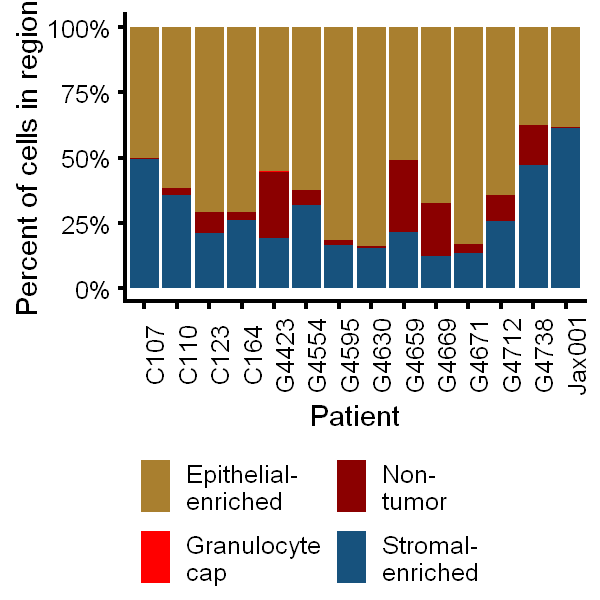

In [15]:
options(repr.plot.width = 2, repr.plot.height = 2, repr.plot.res = 300)
tessera_palette = c('Epithelial-enriched' =  '#A97F2F', 
"Stromal-enriched" = '#17527D', 'Granulocyte cap' = 'red', "Non-tumor" = 'darkred'
                   )
names(tessera_palette) = str_wrap(names(tessera_palette), width = 7, whitespace_only = FALSE) 
fig2e = sheet4 %>%
    mutate(tessera_annotation = str_wrap(tessera_annotation, width = 7, whitespace_only = FALSE)) %>%
    ggplot(., aes(x = PatientID, fill = tessera_annotation, y = Number_of_Cells)) +
    geom_bar(position="fill", stat="identity") +
    xlab('Patient') +
    ylab('Percent of cells in region') +
    theme(axis.text.x = element_text(angle = 90, size = 8)) + 
    scale_y_continuous(name = "Percent of cells in region", labels = scales::label_percent(accuracy = 1)) +
    cowplot::theme_half_open(7) +
    scale_fill_manual(values = tessera_palette, name = '') + #Tessera annotations
    theme(legend.position = 'bottom', axis.text.x = element_text(angle = 90)) +
  guides(fill = guide_legend(nrow = 2)) +
  # 3. MODIFICATION 2: Remove facet label background
  # We do this by modifying the 'strip.background' element
  theme(
    strip.background = element_blank(), # Removes background fill and border
    
    # Optional: You might want to make the facet text bold
    # or a different color now that it has no background.
    strip.text = element_text(size = 7)
  ) + NULL
fig2e

Loading required package: patchwork



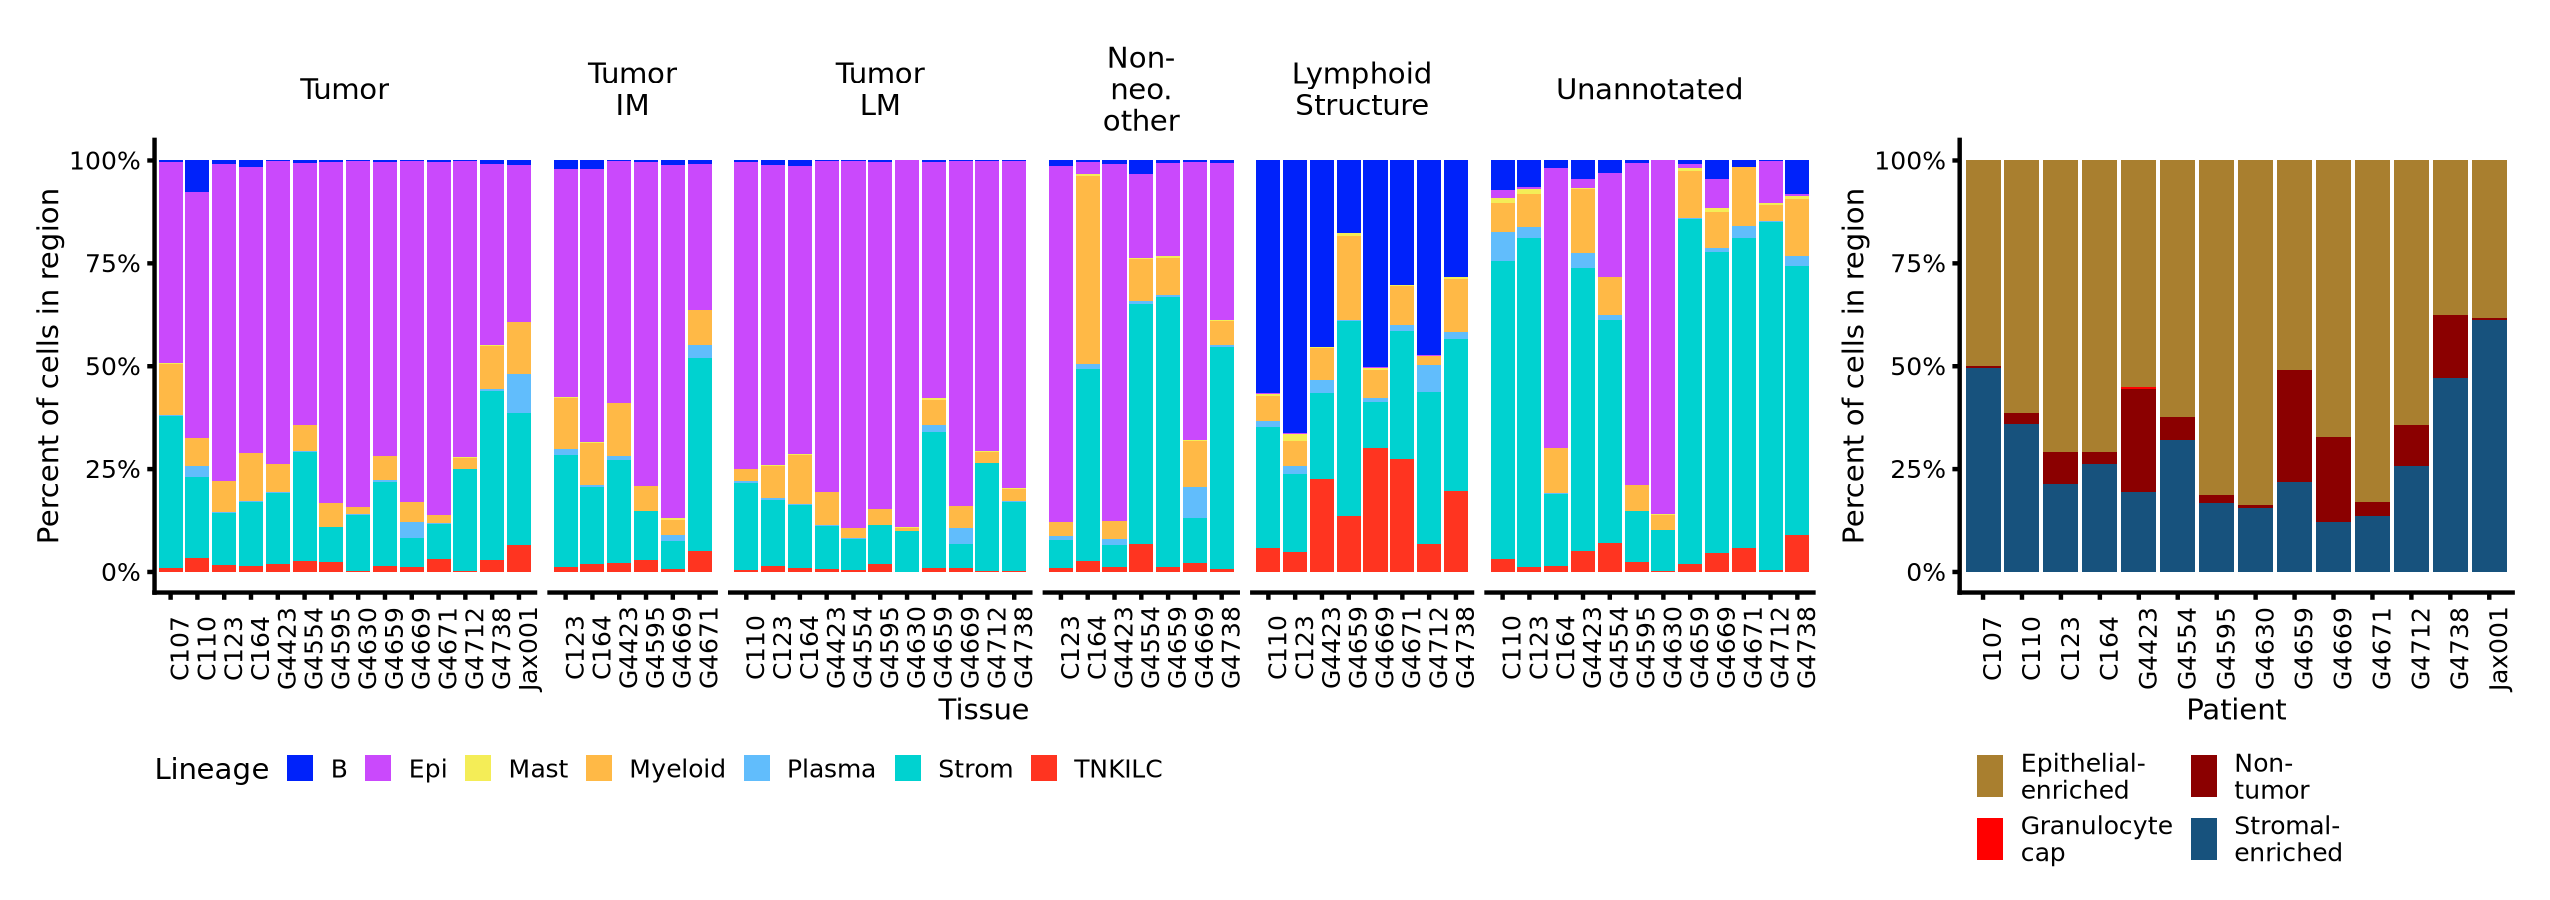

In [23]:
require(patchwork)
options(repr.plot.width = 8.5, repr.plot.height = 3, repr.plot.res = 300)

fig2c_expanded + fig2e + plot_layout(design = 'AAAAAAAAABBB', guides = 'keep')

In [24]:
pdf('figs/suppfig2_a_and_e.pdf', width = 8.25, height = 2.5)
fig2c_expanded + fig2e + plot_layout(design = 'AAAAAAAAABBB', guides = 'keep')
dev.off()

agg_record_242117775 
                   2

In [26]:
pdf('figs/suppfig2_a.pdf', width = 6.25, height = 2.5)
fig2c_expanded
dev.off()

pdf('figs/suppfig2_e.pdf', width = 2.25, height = 2.5)
fig2e
dev.off()

agg_record_2049218514 
                    2

agg_record_2049218514 
                    2